## NLP-based prediction of genres based on their lyrics: II. Exploratory Data Analysis

In [69]:
import pandas as pd
import numpy as np
import nltk
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

In [133]:
# Read the lemmatized dataset
songs = pd.read_csv('data/lemmatized_lyrics.csv')

In [71]:
# A general view of the lemmatized lyrics reveals that the outcome of lemmatization 
# has led to empty lists in some cases (7)
songs.describe()

,lyrics,genre,language
count,92900,92900,92900
unique,92666,5,1
top,[],Country,en
freq,7,18580,92900


In [72]:
# Removing empty list lyrics and other variations of empty content
songs = songs[songs.lyrics!='[]']
songs = songs[songs.lyrics!='[\'instrumental\']']
songs = songs[songs.lyrics!='[\'lyric\', \'instrumental\']']
songs.describe()

,lyrics,genre,language
count,92883,92883,92883
unique,92663,5,1
top,"['chestnut', 'roast', 'open', 'fire', 'jack', 'frost', 'nip', 'nose', 'yuletide', 'carol', 'sing...",Hip-hop,en
freq,4,18580,92883


In [73]:
# Interestingly, despite our previous removal of duplicate lyrics, lemmatizing reveals some redundancy
songs[songs.duplicated(keep=False)]

,lyrics,genre,language
703,"['high', 'feel', 'love', 'pretend', 'long', 'ago', 'since', 'reason', 'strong', 'true', 'girl', ...",Rock,en
762,"['man', 'alone', 'born', 'stone', 'stamp', 'dust', 'time', 'hand', 'strike', 'flame', 'soul', 't...",Rock,en
1150,"['well', 'carburetor', 'baby', 'clean', 'checked', 'line', 'blow', 'hummin', 'like', 'turbojet',...",Rock,en
2000,"['come', 'home', 'today', 'season', 'spend', 'away', 'hard', 'see', 'hard', 'say', 'like', 'face...",Rock,en
2635,"['come', 'home', 'today', 'season', 'spend', 'away', 'hard', 'see', 'hard', 'say', 'like', 'face...",Rock,en
...,...,...,...
92546,"['love', ""'s"", 'go', 'live', 'oh', 'sun', ""'s"", 'go', 'shine', 'life', 'love', ""'s"", 'go', 'live...",Country,en
92547,"['make', 'dream', 'come', 'true', 'turn', 'sky', 'blue', 'love', 'like', 'far', 'apart', 'break'...",Country,en
92552,"['ever', 'get', 'south', 'cincinnati', 'dogwood', 'tree', 'grow', 'ever', 'get', 'south', 'mason...",Country,en
92635,"['ever', 'get', 'south', 'cincinnati', 'dogwood', 'tree', 'grow', 'ever', 'get', 'south', 'mason...",Country,en


In [74]:
# Duplicates are dropped
songs = songs[~songs.lyrics.duplicated()]
songs.describe()

,lyrics,genre,language
count,92663,92663,92663
unique,92663,5,1
top,"['night', 'come', 'rescue', 'world', 'misery', 'light', 'lovelight', 'shine', 'light', 'time', '...",Rock,en
freq,1,18558,92663


In [75]:
# In order to perform some EDA, our lemmatized lyrics will be needed to be reconverted to single strings for some
# functionality. A new temp column is added. Inspiration drawn from: https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d

# Our list is interpreted as a string by pd.read_csv, so we first convert it back to a list
songs.lyrics = songs.lyrics.apply(ast.literal_eval)

# Now we create the new column
songs['lyrics_str'] = [' '.join(map(str,lemmatized)) for lemmatized in songs.lyrics]
songs.head()

,lyrics,genre,language,lyrics_str
0,"[2, ``, ``, ``, ``, ``, ``]",Rock,en,2 `` `` `` `` `` ``
1,"[finger, white, like, whisper, lips, consume, flame, lack, good, thing, set, fire, knee, red, li...",Rock,en,finger white like whisper lips consume flame lack good thing set fire knee red like rumor gossip...
2,"[need, know, much, want, broken, die, need, know, much, want, care, want, breathe, like, cigaret...",Rock,en,need know much want broken die need know much want care want breathe like cigarette want hold de...
3,"[ask, feel, love, real, know, make, look, frown, would, like, drive, town, want, around, believe...",Rock,en,ask feel love real know make look frown would like drive town want around believe show door say ...
4,"[want, play, background, couple, drink, wine, would, triumph, voice, like, mine, everybody, want...",Rock,en,want play background couple drink wine would triumph voice like mine everybody want feel sexy so...


The output above reveals some data cleaning is still in order. Below we remove lyrics that are below a discretionary length threshhold. 

In [93]:
songs['length'] = songs.lyrics_str.apply(lambda x: len(x))
songs = songs[songs.length>25]

In [106]:
songs.to_csv('data/lemmatized_lyrics.csv', index=False)

In [107]:
# Attaching TextBlob sentiment analysis
songs['TB_sentiment'] = songs['lyrics_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Attaching Vader sentiment analysis
vader = SentimentIntensityAnalyzer()
songs['V_sentiment'] = songs['lyrics_str'].apply(lambda x: vader.polarity_scores(x)['compound'])

songs.head()

,lyrics,genre,language,lyrics_str,length,TB_sentiment,V_sentiment
1,"[finger, white, like, whisper, lips, consume, flame, lack, good, thing, set, fire, knee, red, li...",Rock,en,finger white like whisper lips consume flame lack good thing set fire knee red like rumor gossip...,434,0.054167,0.9287
2,"[need, know, much, want, broken, die, need, know, much, want, care, want, breathe, like, cigaret...",Rock,en,need know much want broken die need know much want care want breathe like cigarette want hold de...,477,0.036667,-0.8176
3,"[ask, feel, love, real, know, make, look, frown, would, like, drive, town, want, around, believe...",Rock,en,ask feel love real know make look frown would like drive town want around believe show door say ...,625,0.114815,0.9661
4,"[want, play, background, couple, drink, wine, would, triumph, voice, like, mine, everybody, want...",Rock,en,want play background couple drink wine would triumph voice like mine everybody want feel sexy so...,403,0.327273,0.9904
5,"[step, step, inch, inch, draw, close, id, wish, little, touch, spark, itch, creep, tell, hong, k...",Rock,en,step step inch inch draw close id wish little touch spark itch creep tell hong kong hong kong fu...,519,-0.137083,0.6621


As demonstrated above, different sentiment analyzers might produce vastly different evaluations in a scale from -1 to 1. In this case, we will likely favor the TextBlob analyzer as it relies less on full sentence structure than Vader.

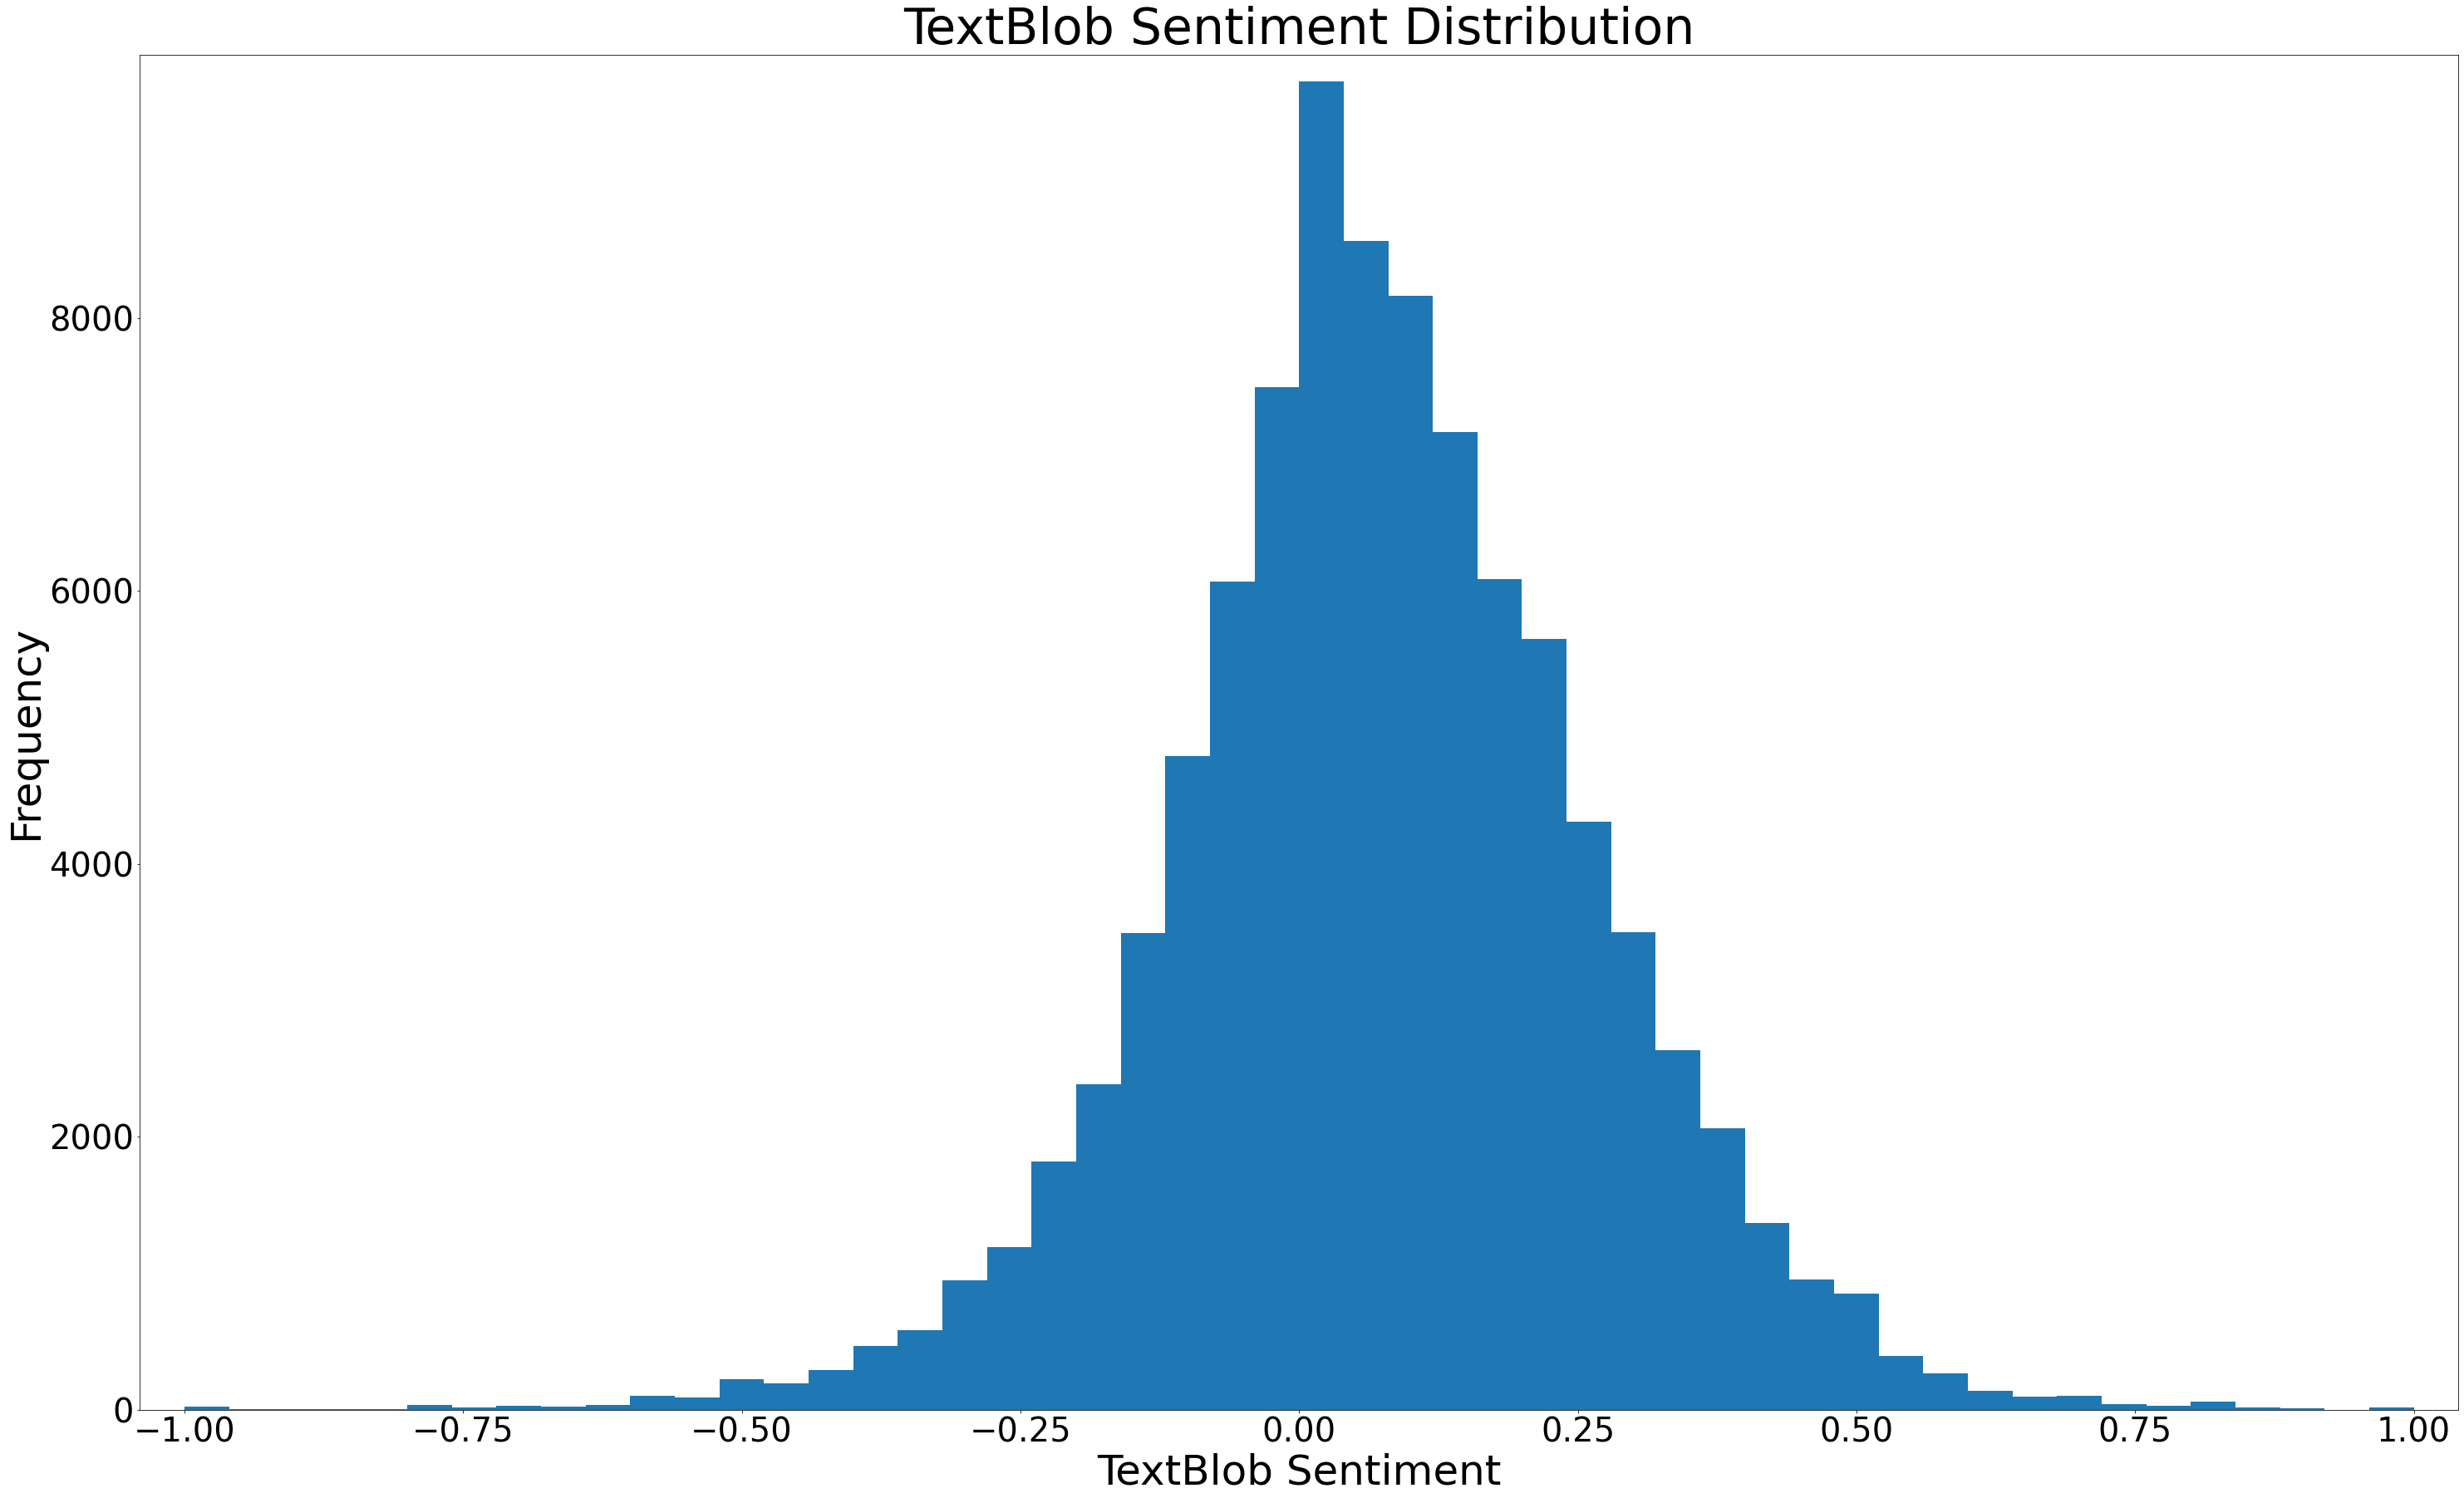

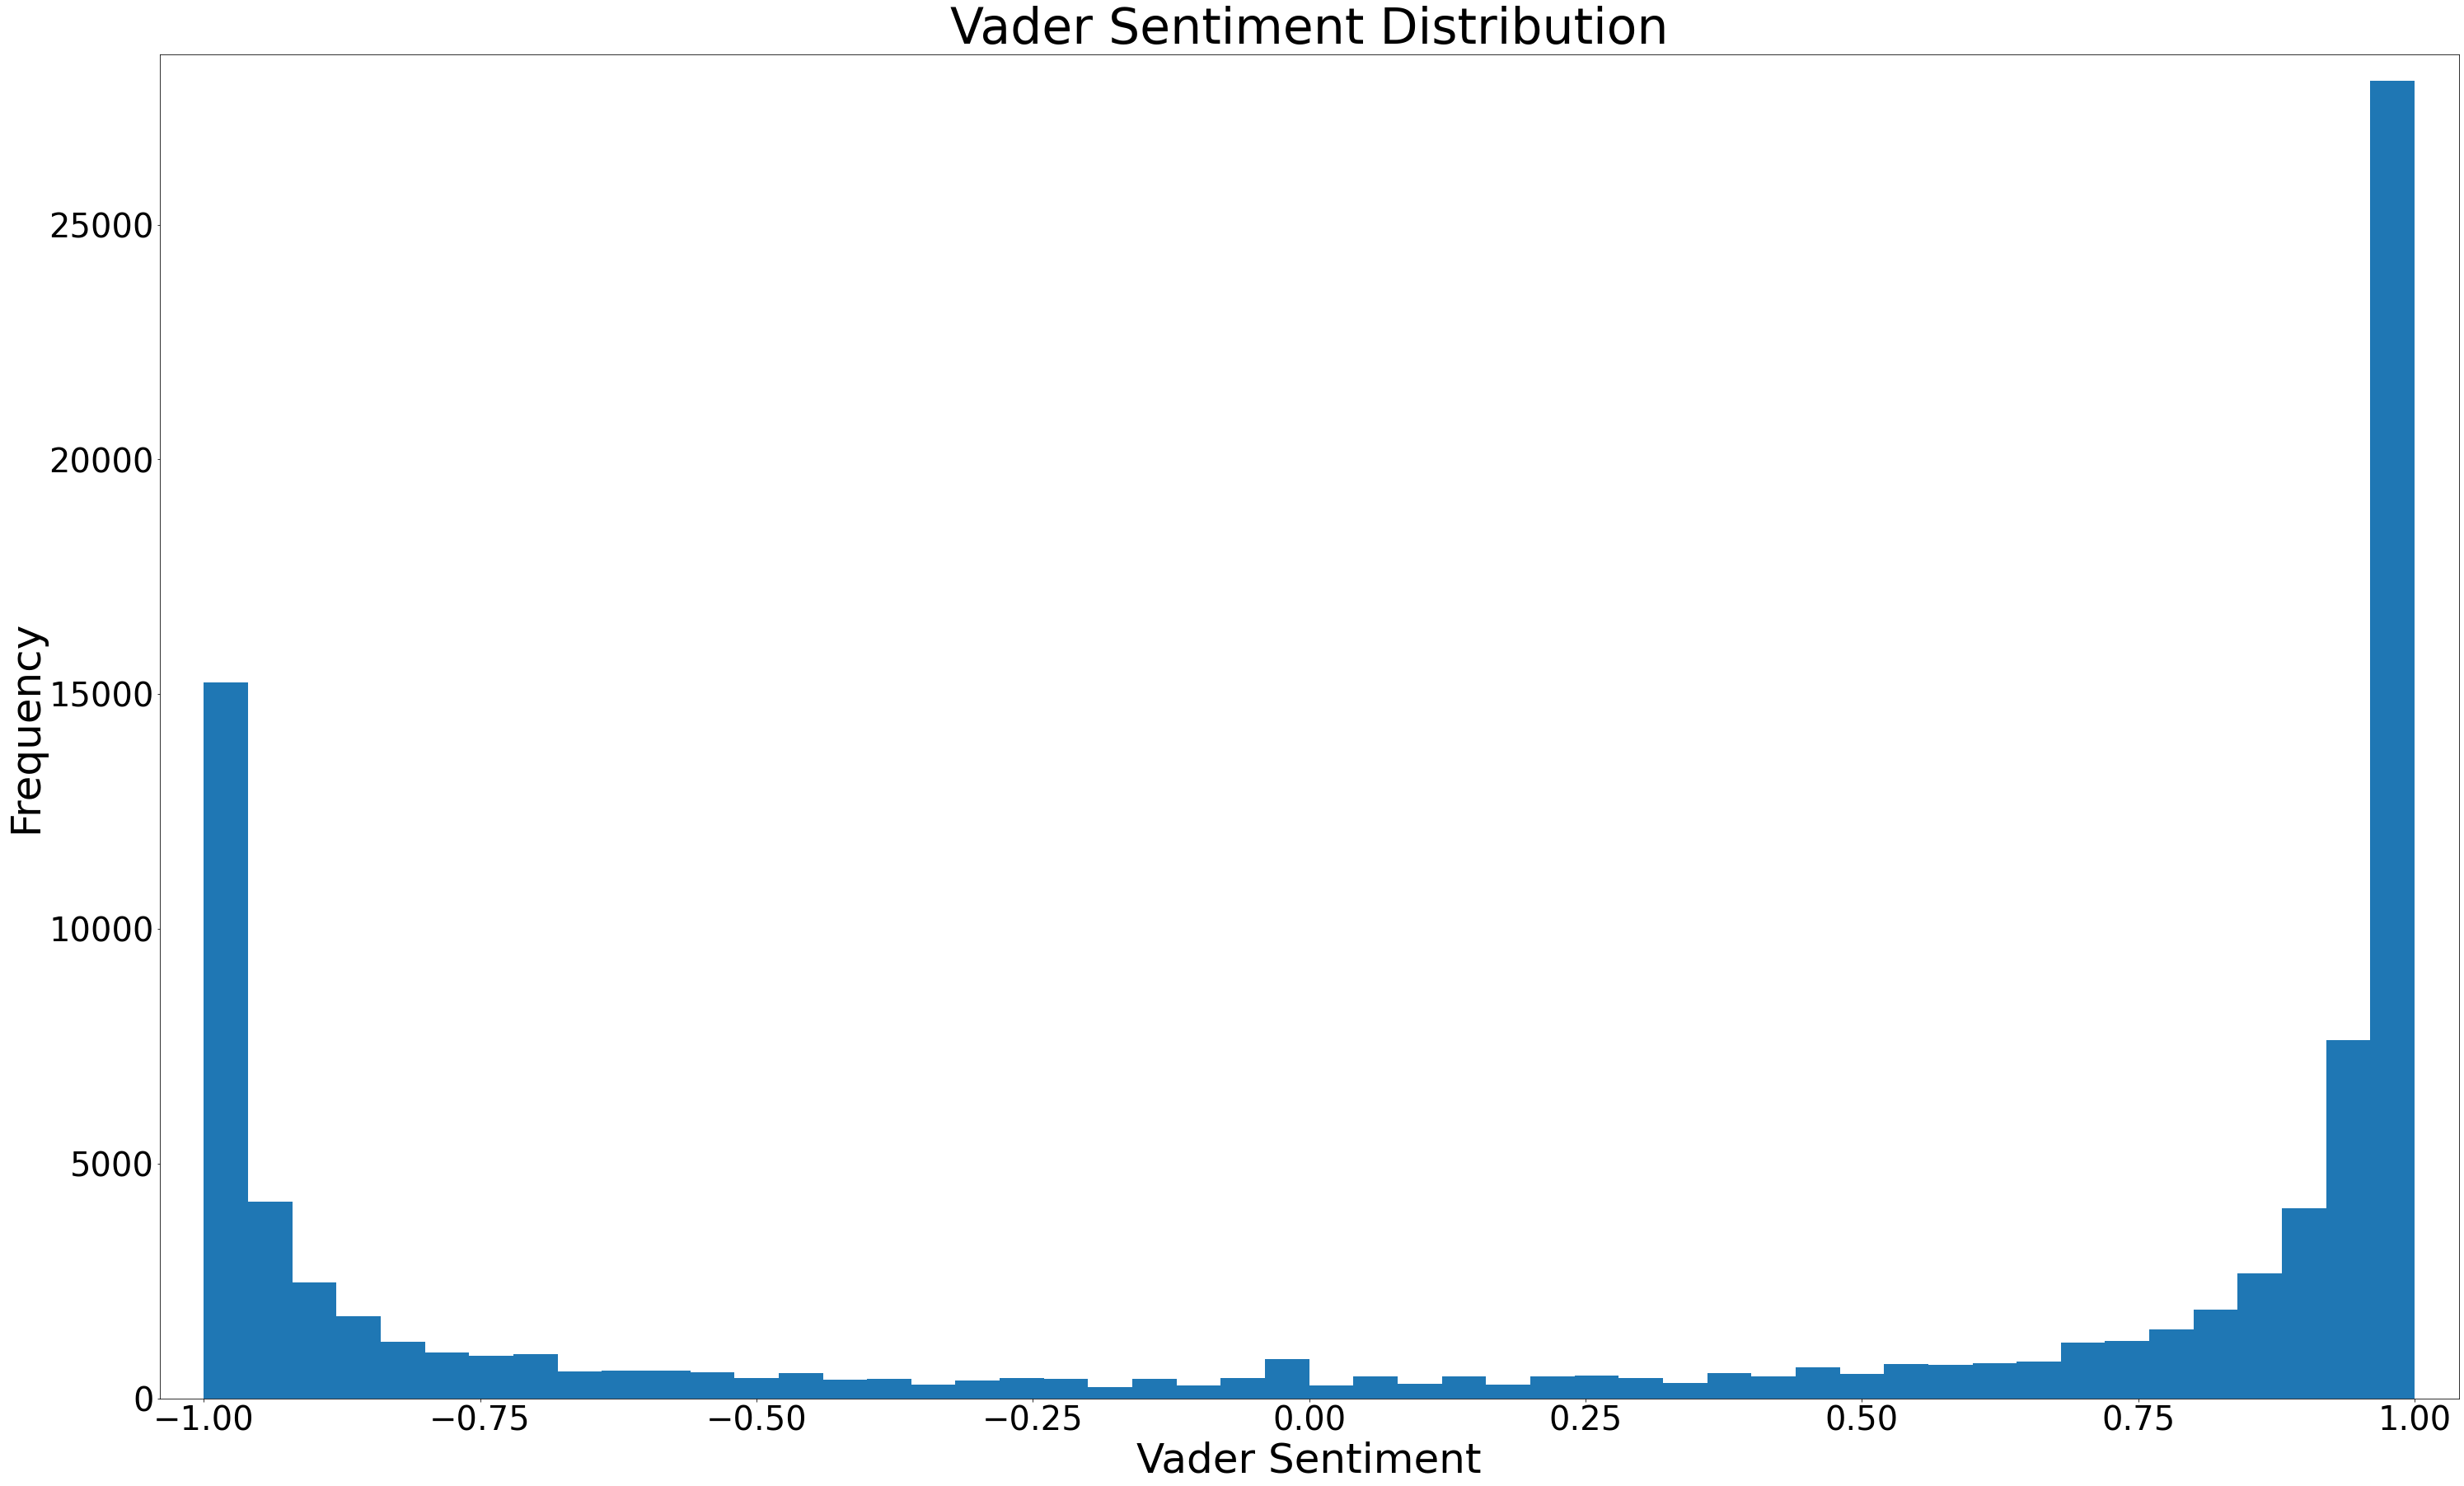

In [108]:
# What is the overall sentiment distribution in this corpus? How do the two sentiment analyzers analyze the corpus?

plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('TextBlob Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(songs.TB_sentiment, bins=50)
plt.title('TextBlob Sentiment Distribution', fontsize=60)
plt.show()

plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Vader Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(songs.V_sentiment, bins=50)
plt.title('Vader Sentiment Distribution', fontsize=60)
plt.show()

The figures above further reinforce differences in sentiment analysis according to which packages are used. Vader is quicker to polarize, and TextBlob is more moderate, yielding an almost normal distribution.

In [109]:
# What is the average sentiment per genre according to the two sentiment analyzers?
bar = songs.groupby('genre')[['TB_sentiment','V_sentiment']].mean()
bar.reset_index(inplace=True)
bar = bar.melt('genre', var_name='sentiment', value_name='values')

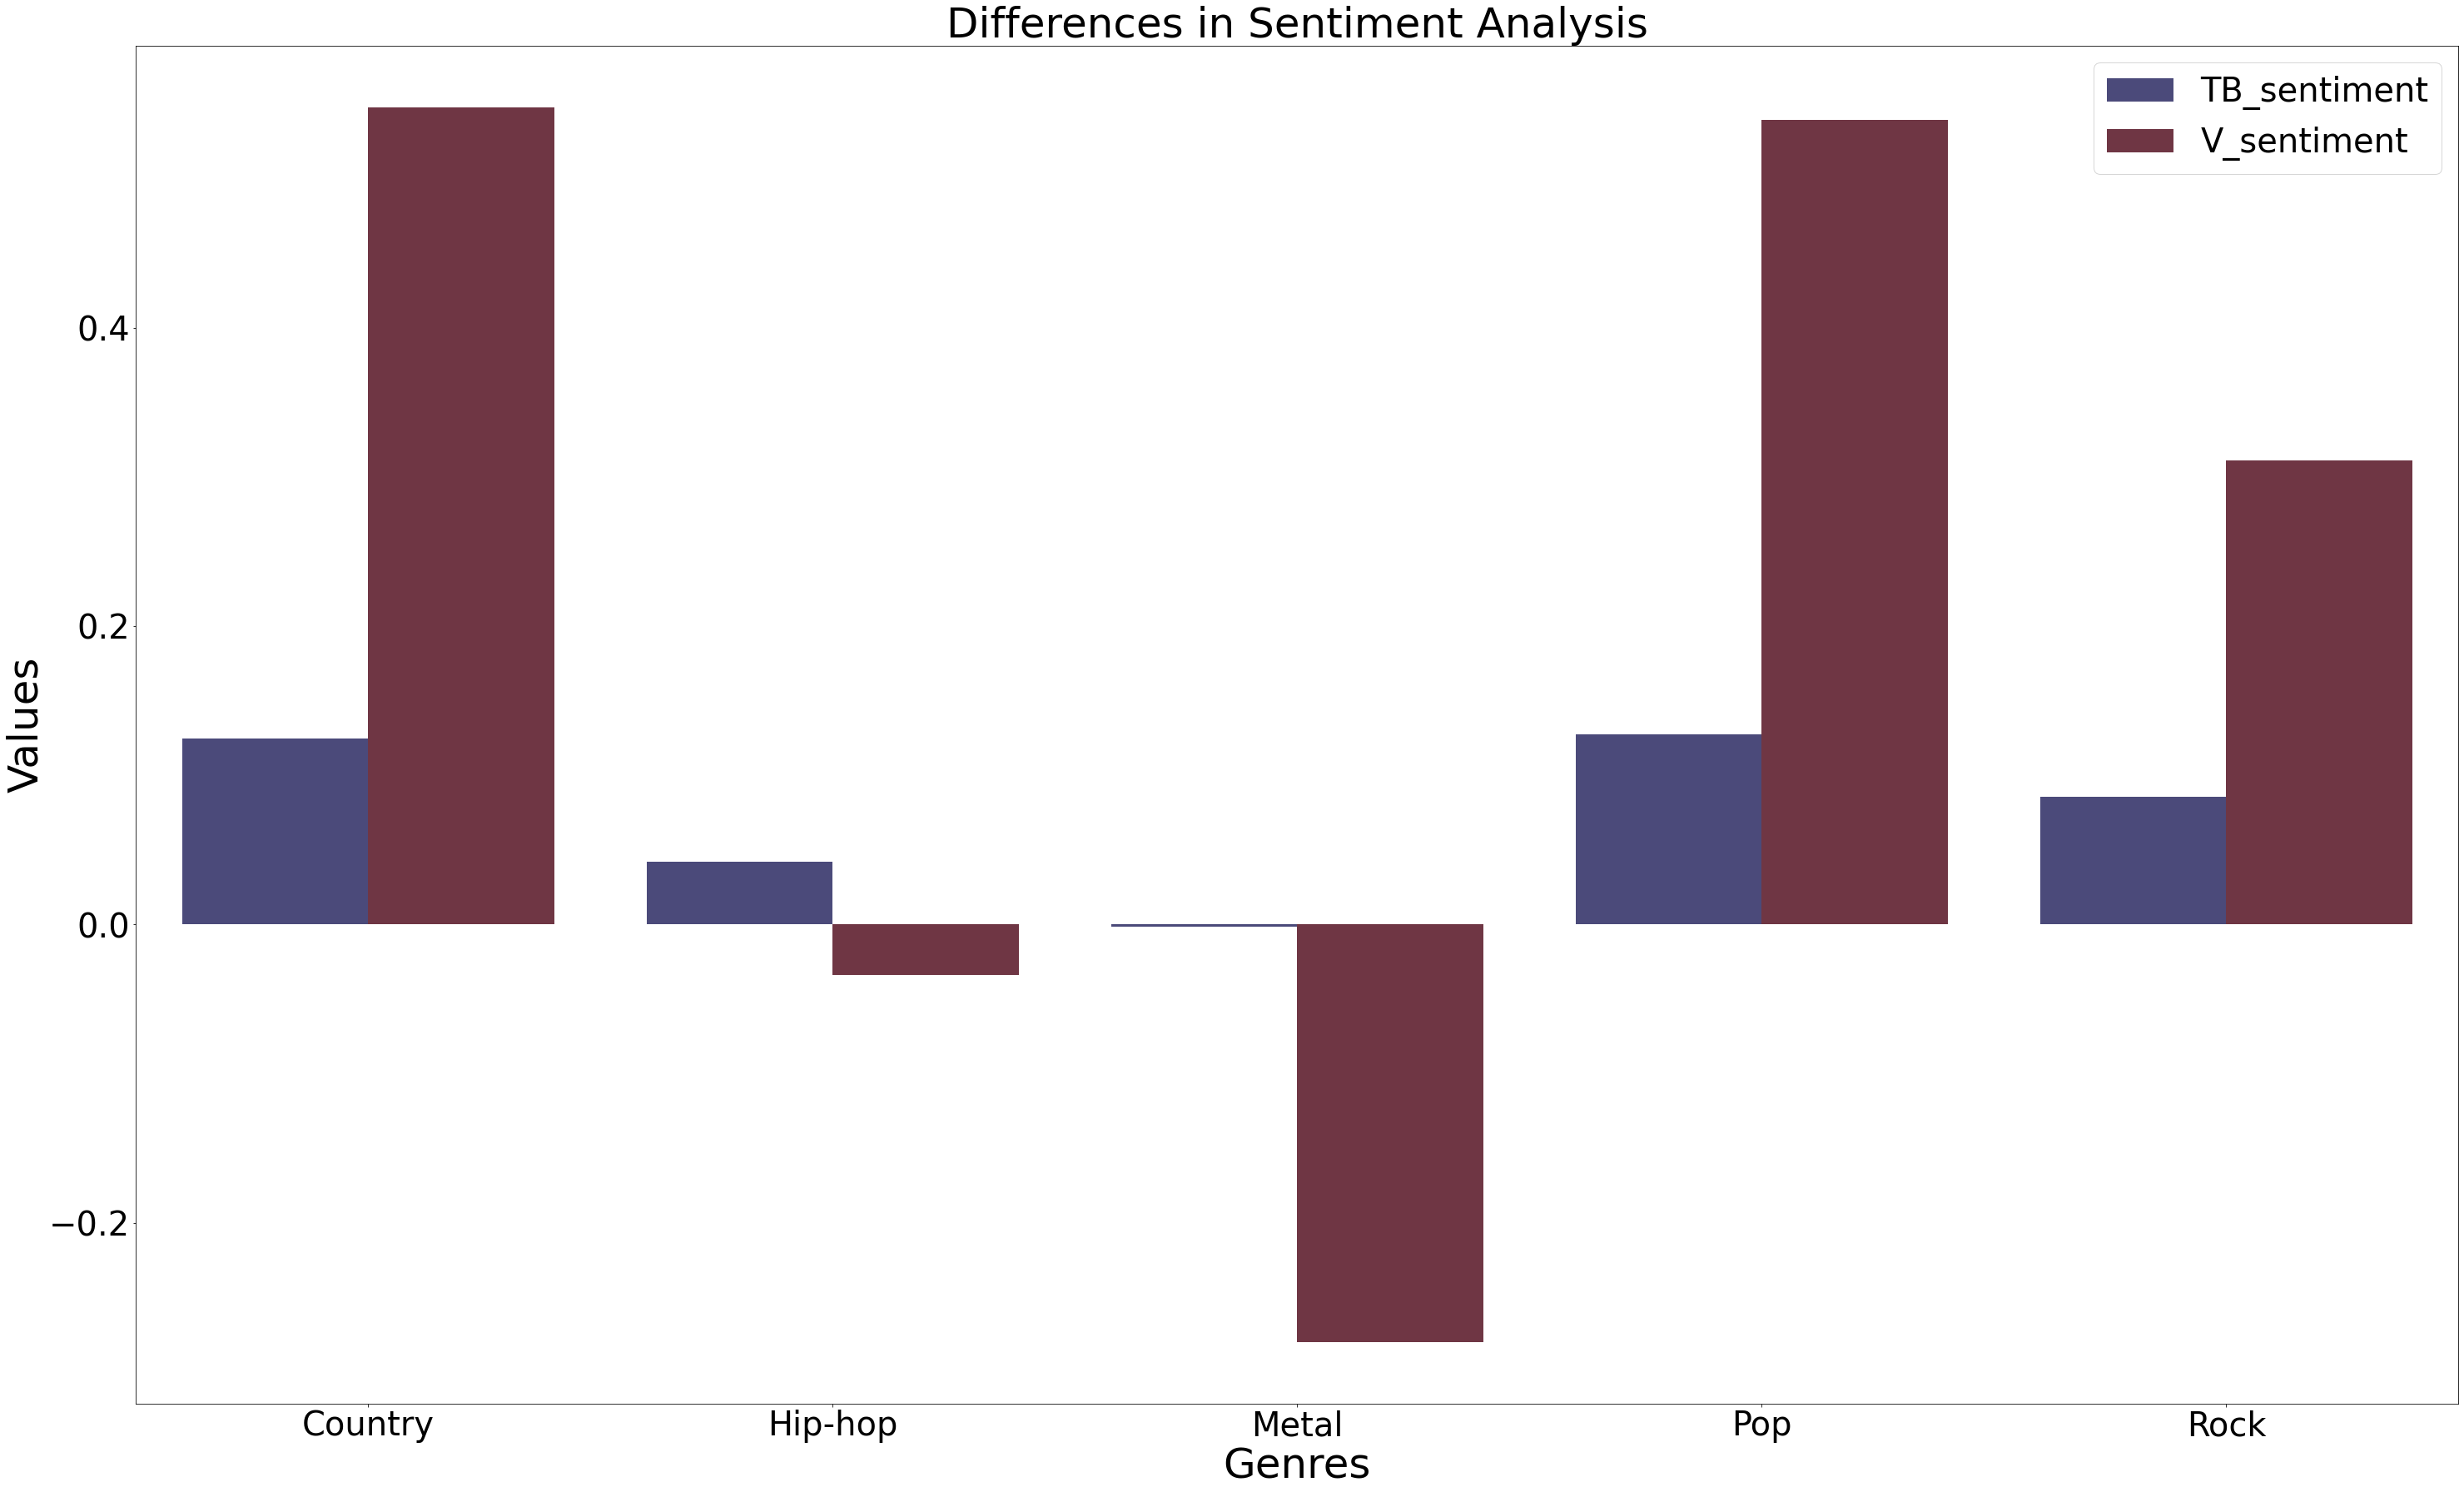

In [110]:
plt.figure(figsize=(50,30))
ax = sns.barplot(x='genre', y='values', hue='sentiment', data=bar, palette='icefire')
plt.title("Differences in Sentiment Analysis", fontsize=50)
plt.ylabel('Values', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Genres', fontsize=50)
plt.xticks(fontsize=40)
plt.legend(fontsize=40)
plt.show()

Again, we confirm the differences in sentiment encoding produced by TextBlob and Vader.

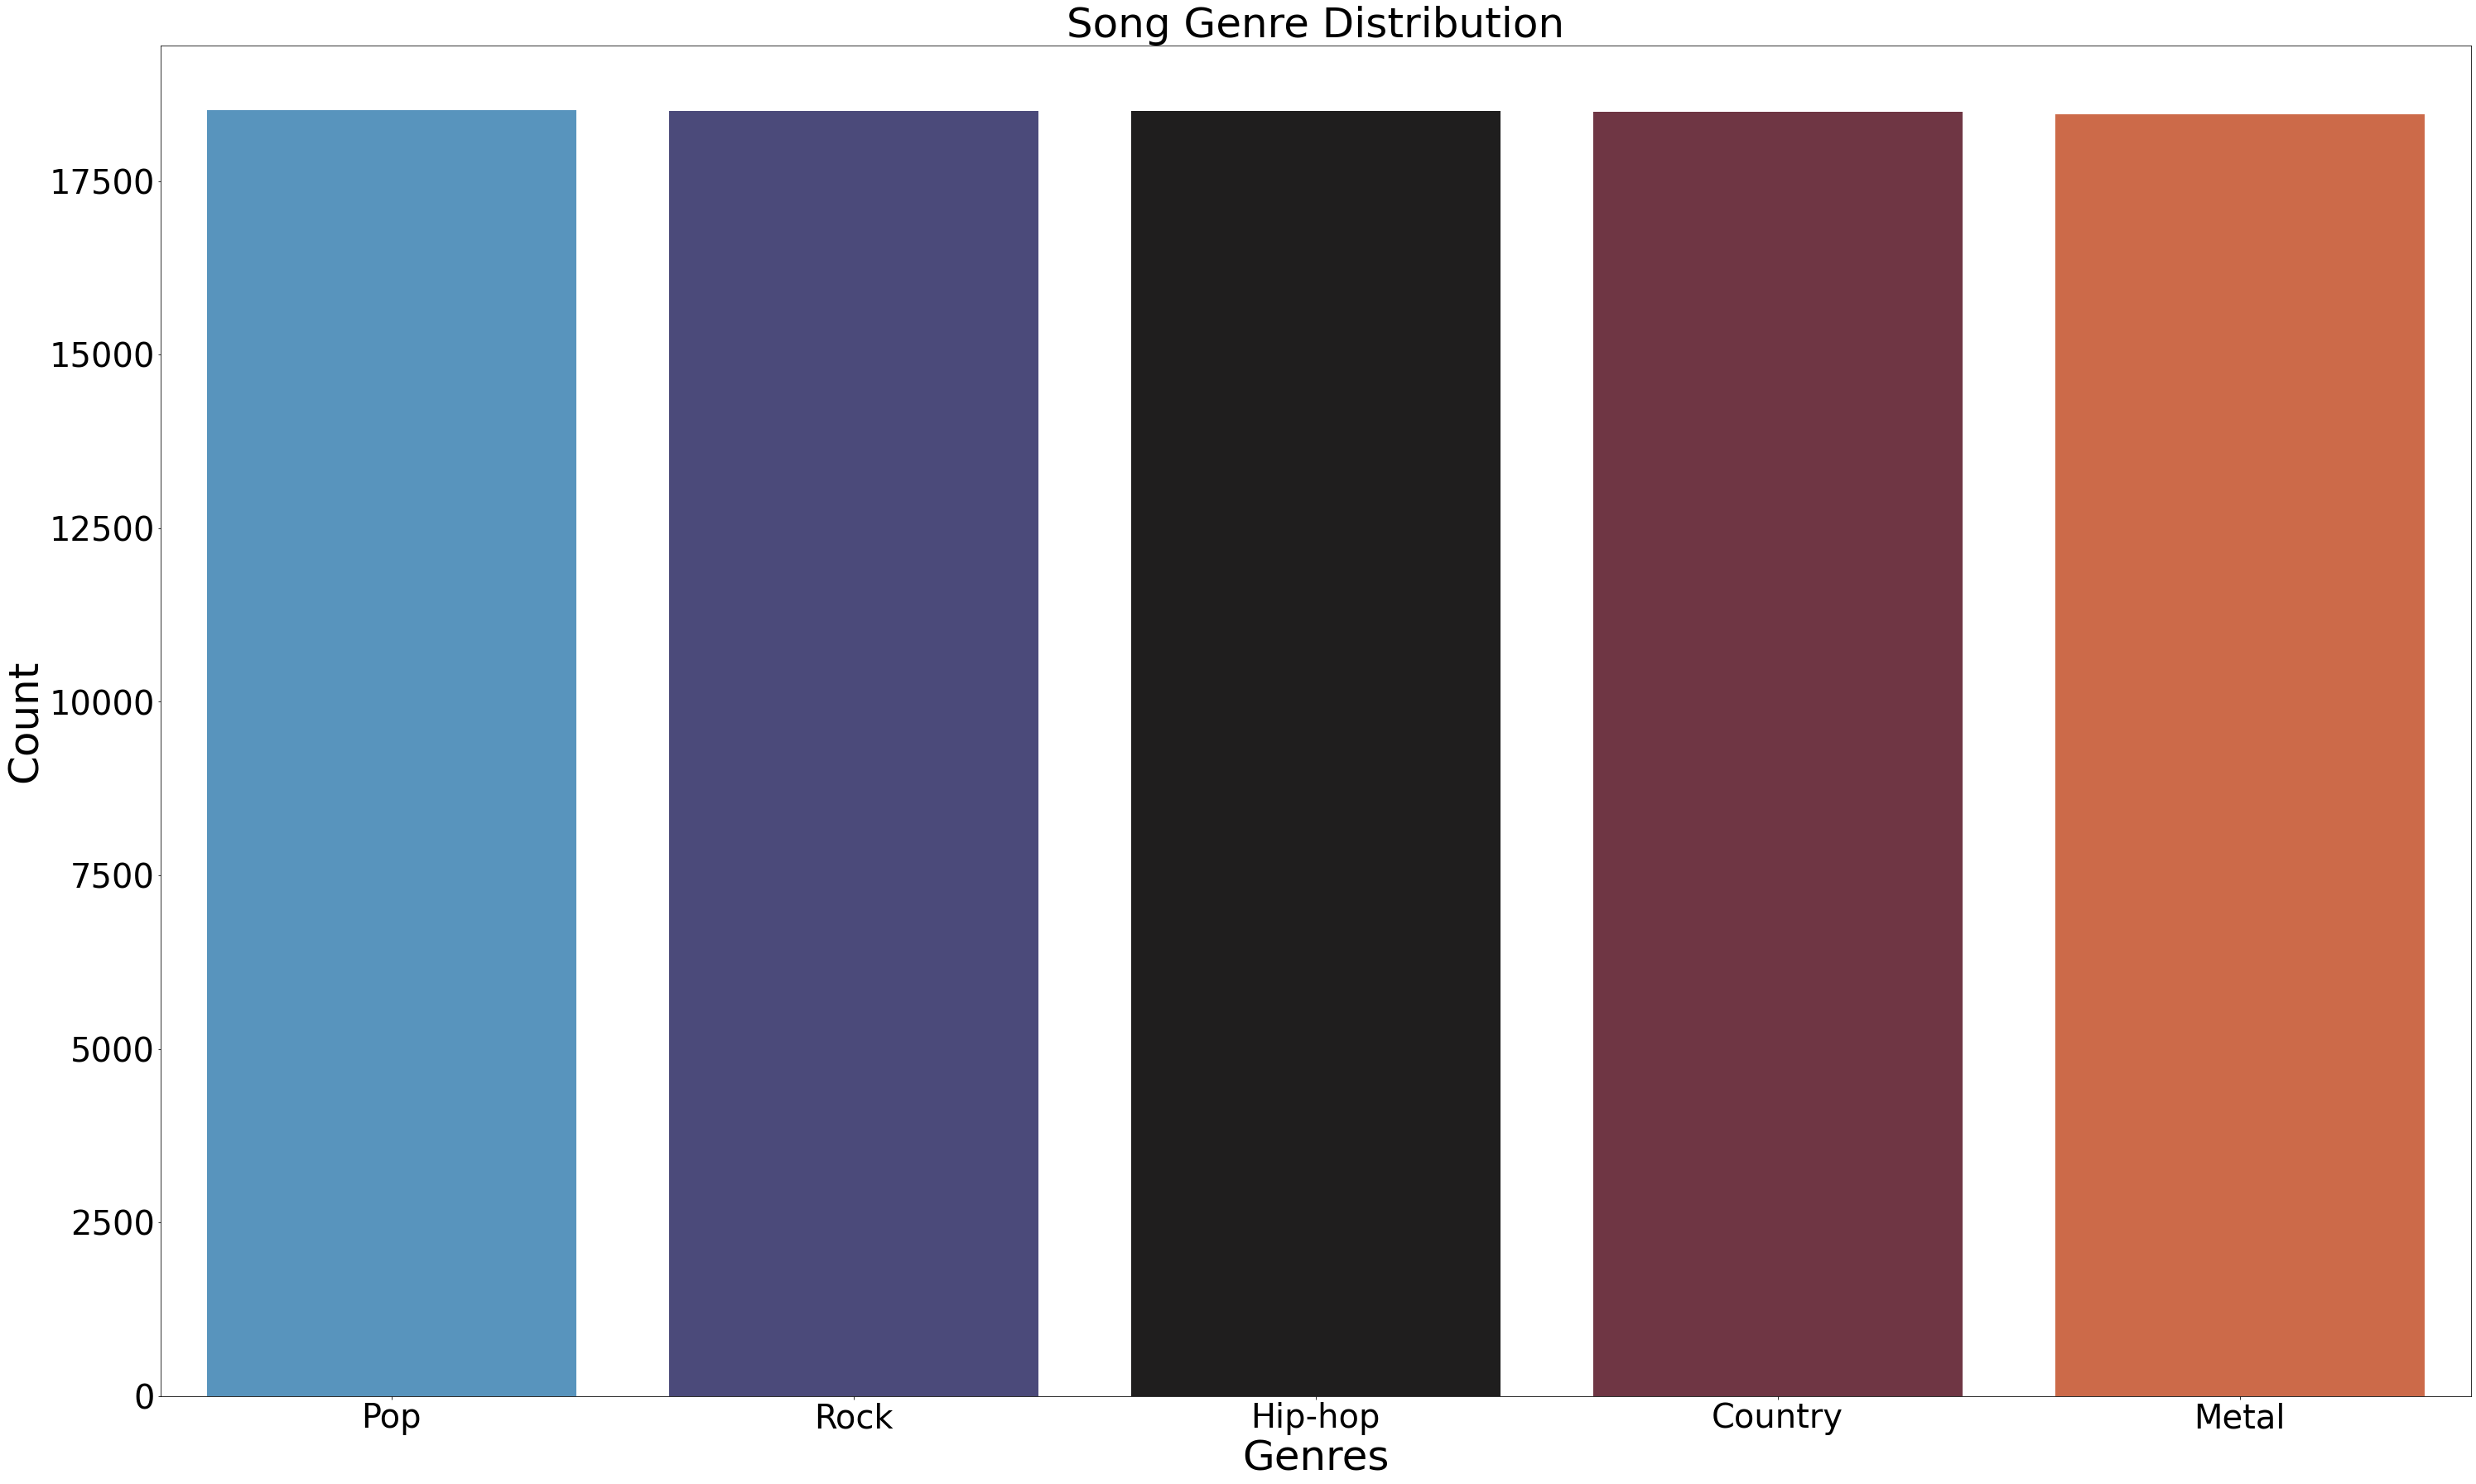

In [111]:
# What is our genre distribution?
x = songs.genre.value_counts()
y = x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x=x.index, y=x.values, palette='icefire')
plt.title("Song Genre Distribution", fontsize=50)
plt.ylabel('Count', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Genres', fontsize=50)
plt.xticks(fontsize=40)
plt.show()

As the figure above demonstrates, we have a classic case of class imbalance in our hands. We will have to decide, prior to training, how we will handle this situation.

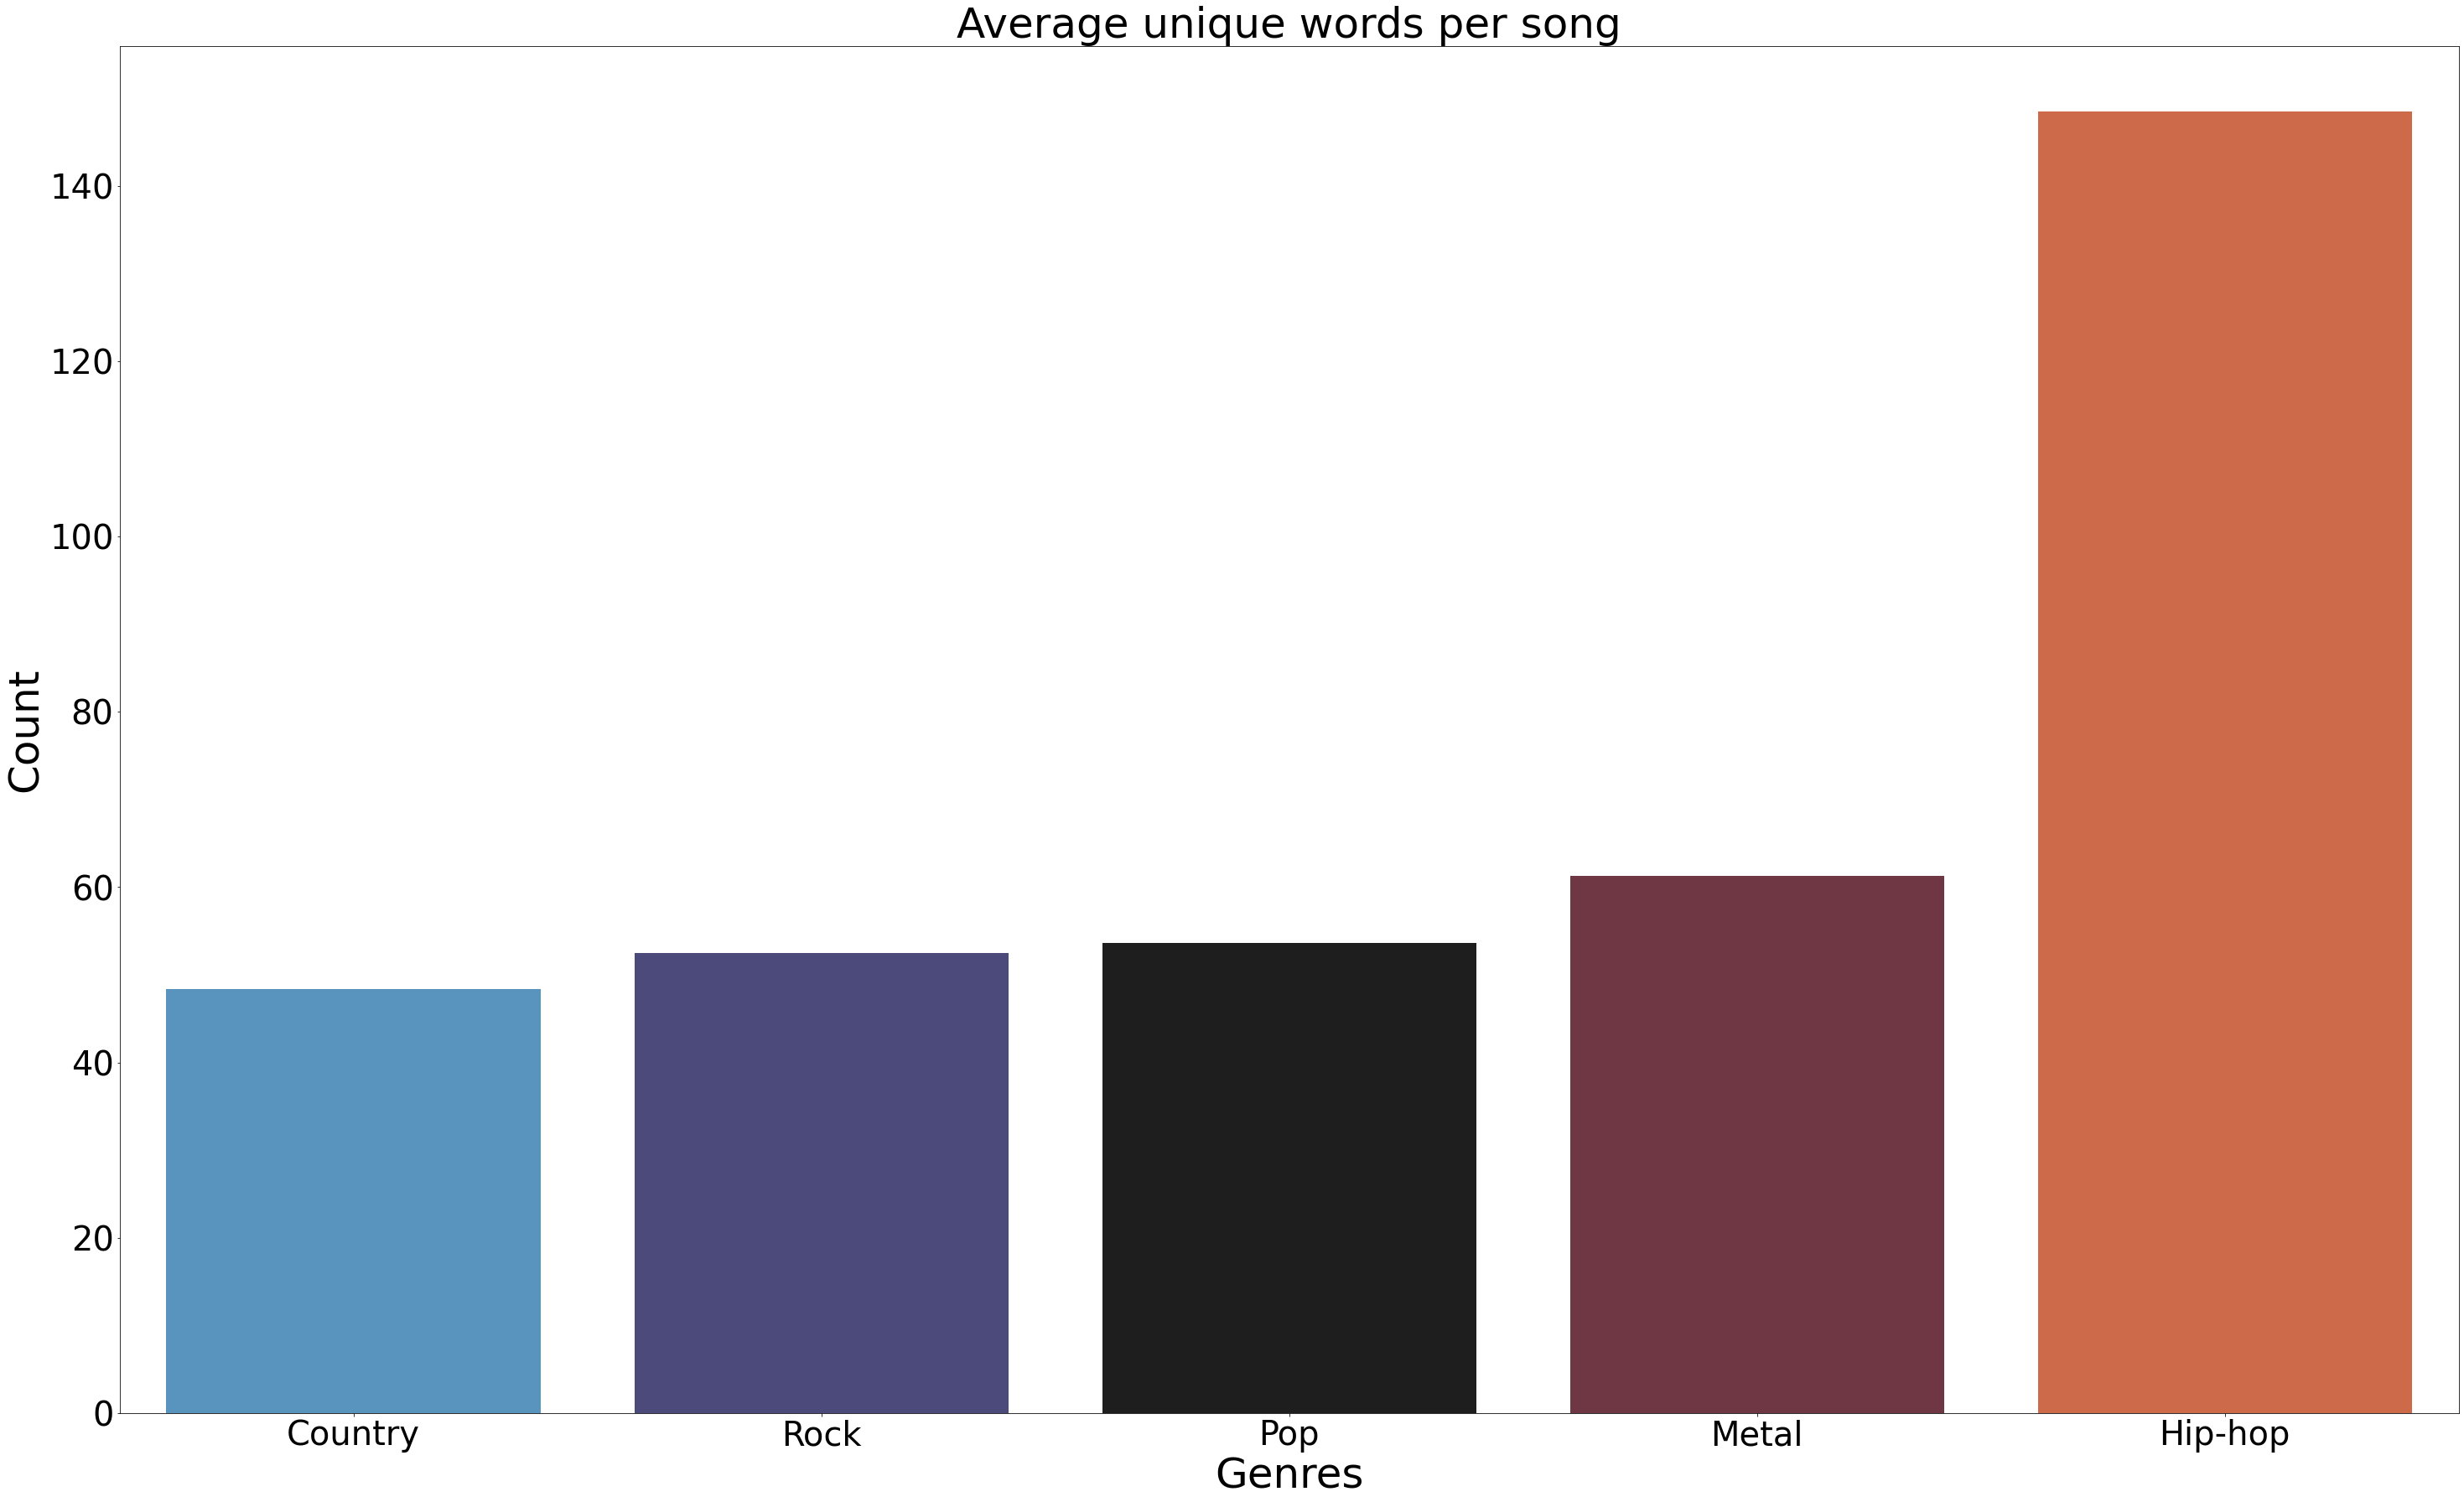

In [112]:
# Which genres use a more diverse vocabulary?

# First, we count the number of unique words per song
songs['unique_words'] = songs.lyrics_str.apply(lambda x: len(set(x.split())))

# We group by genre and calculate the mean
genre_unique_words = songs.groupby("genre").unique_words.mean()

# And we plot a bar graph
genre_unique_words.sort_values(inplace=True)
plt.figure(figsize=(50,30))
sns.barplot(x=genre_unique_words.index, y=genre_unique_words.values, palette='icefire')
plt.title("Average unique words per song", fontsize=50)
plt.ylabel('Count', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Genres', fontsize=50)
plt.xticks(fontsize=40)
plt.show()

Unsuprisingly, hip-hop is an outlier as the more verbose lyrical genre.

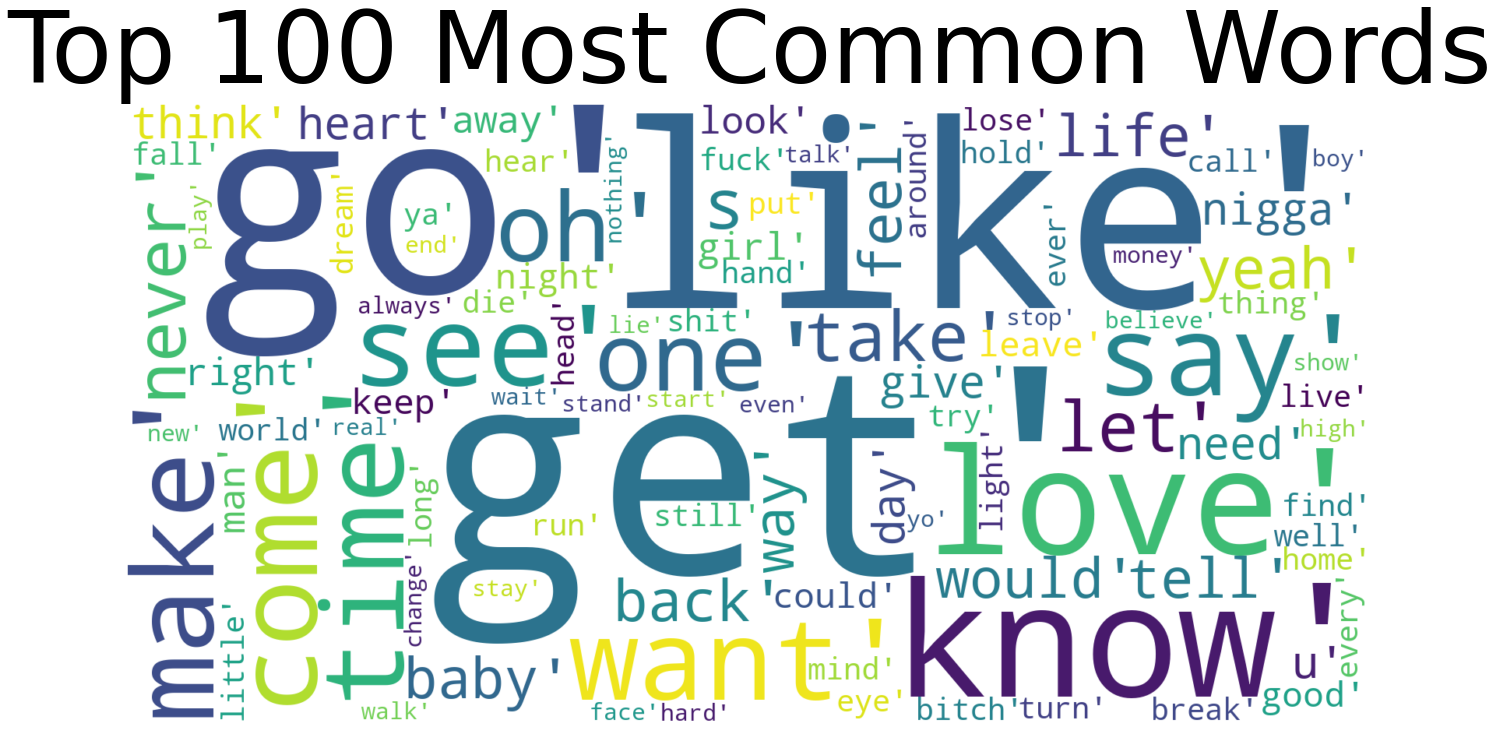

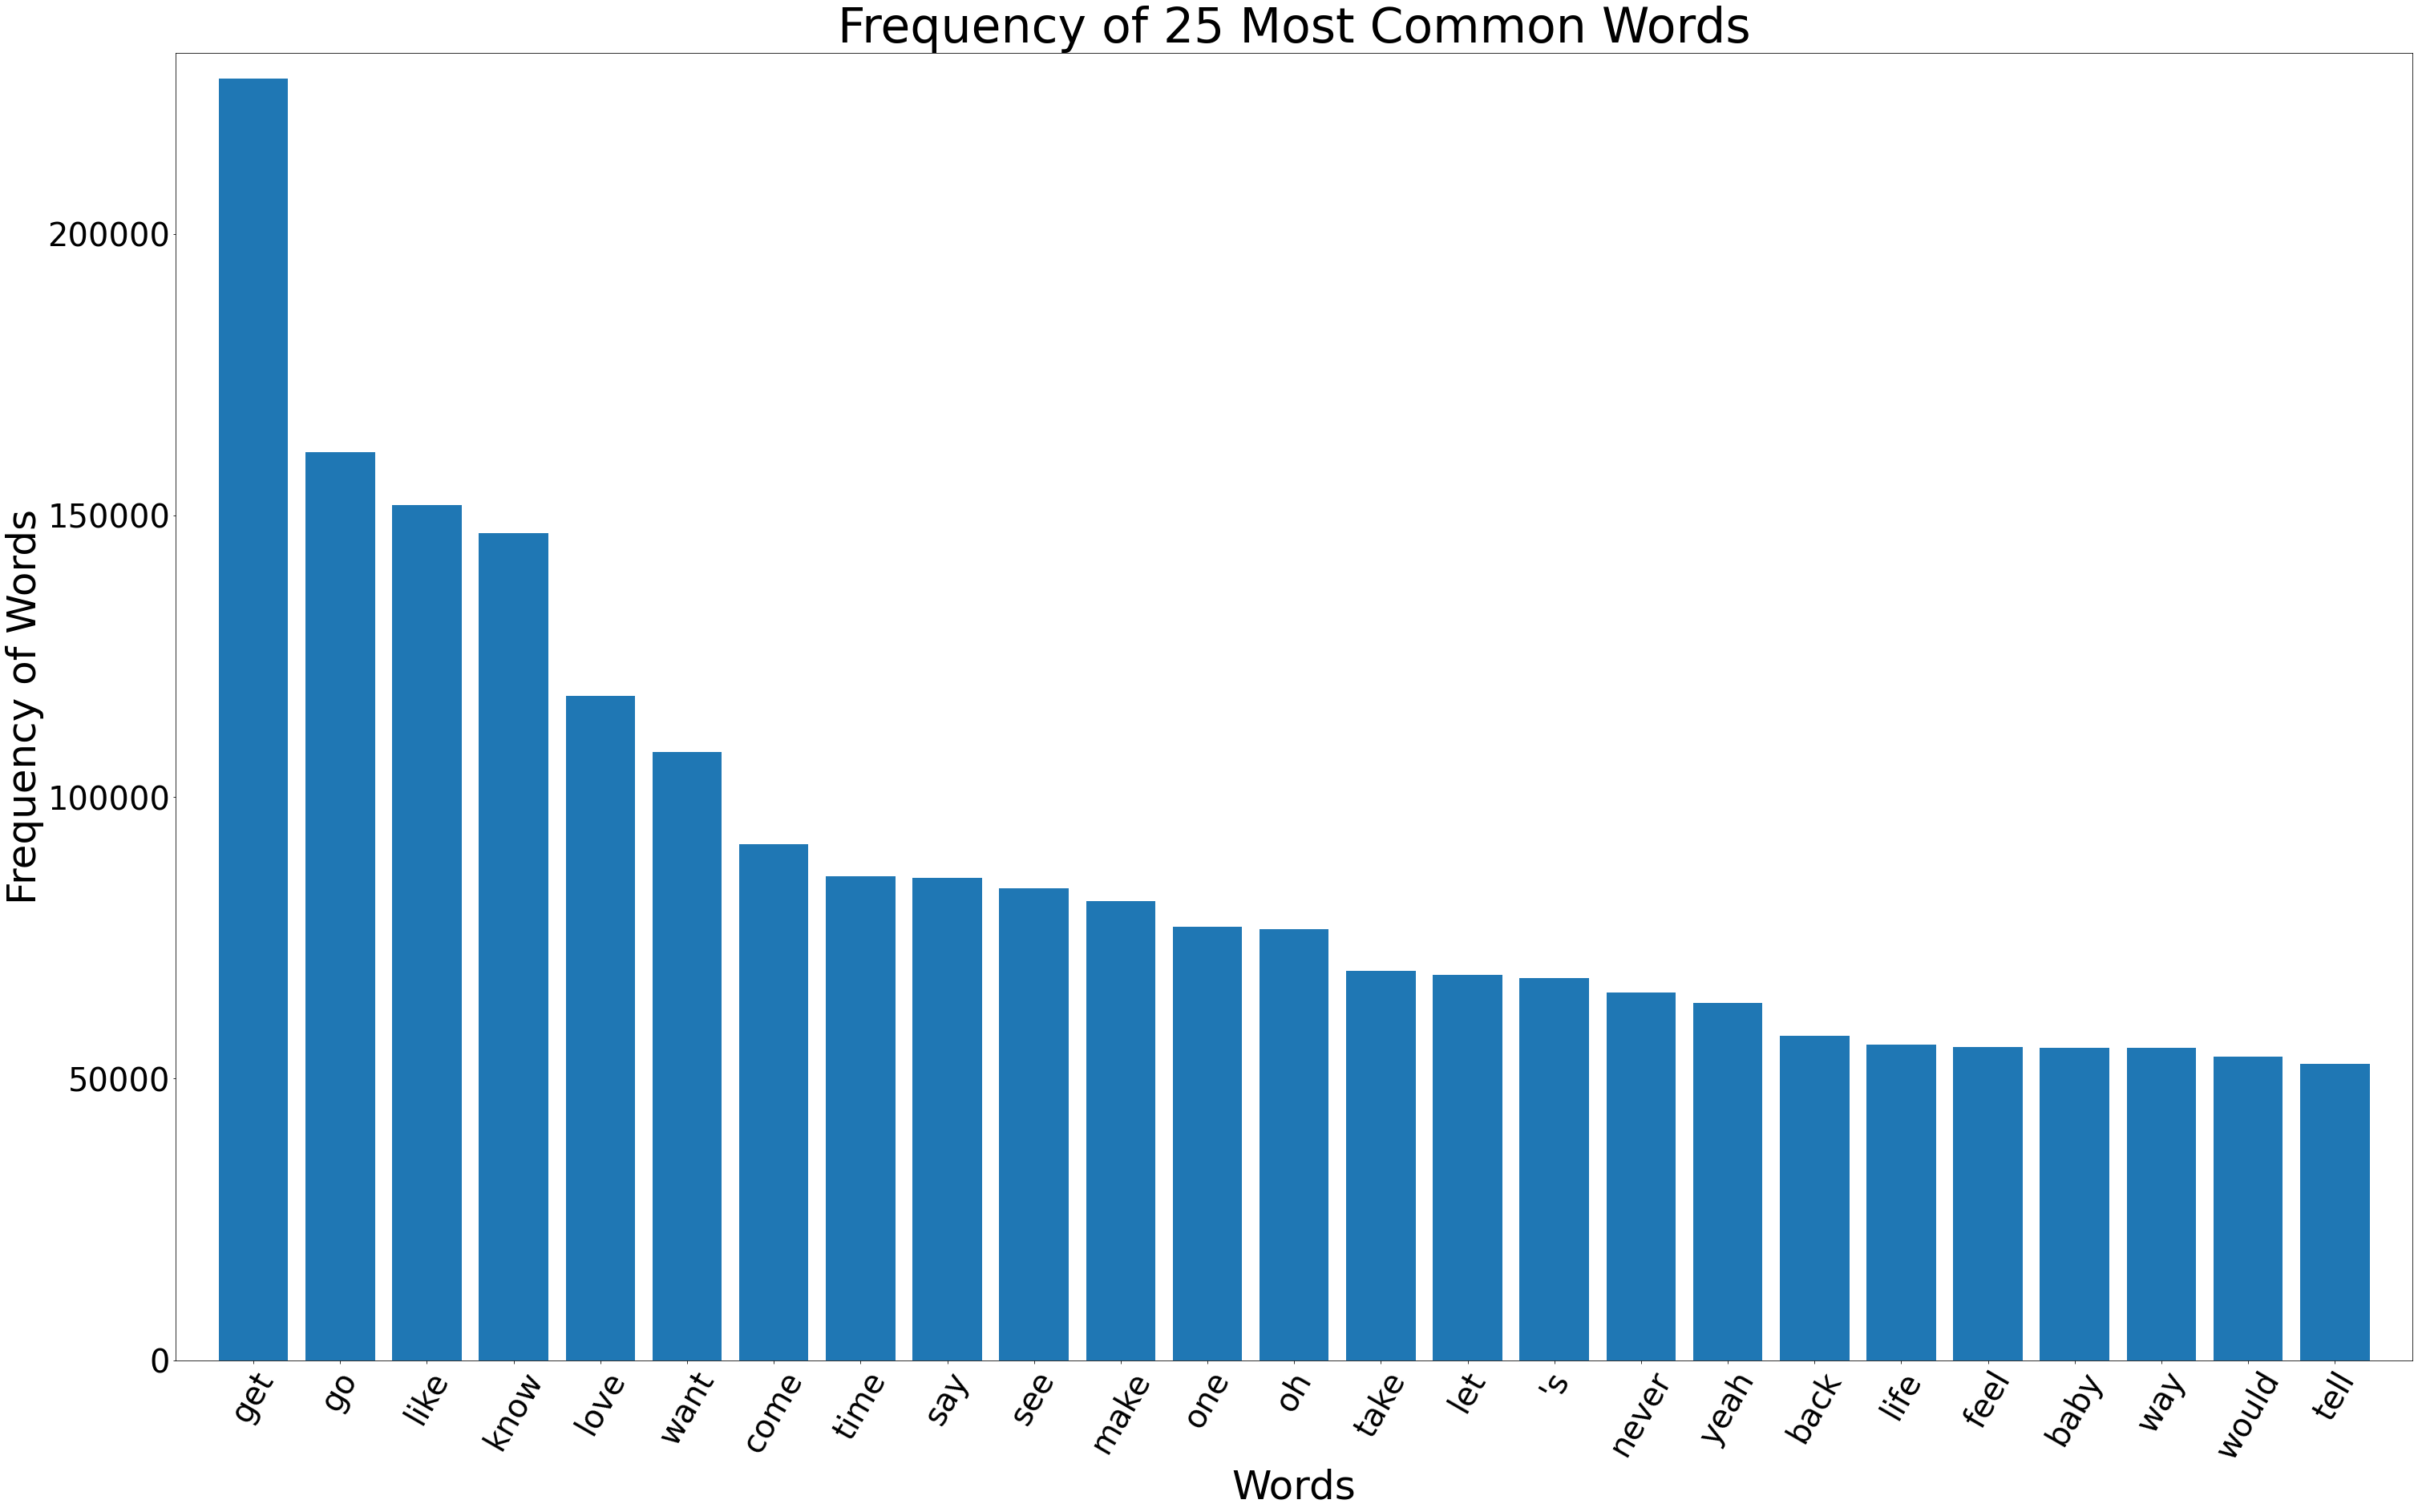

In [113]:
# Term Frequency Analysis: First, we will explore the whole corpus, followed by each individual genre.

# Generating a master list of all words in our corpus
words = songs['lyrics']
allwords = [lyrics for lyrics in songs.lyrics_str]
for wordlist in words:
    allwords += wordlist

# Generate word cloud
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

# Top 25 words across all genres
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()



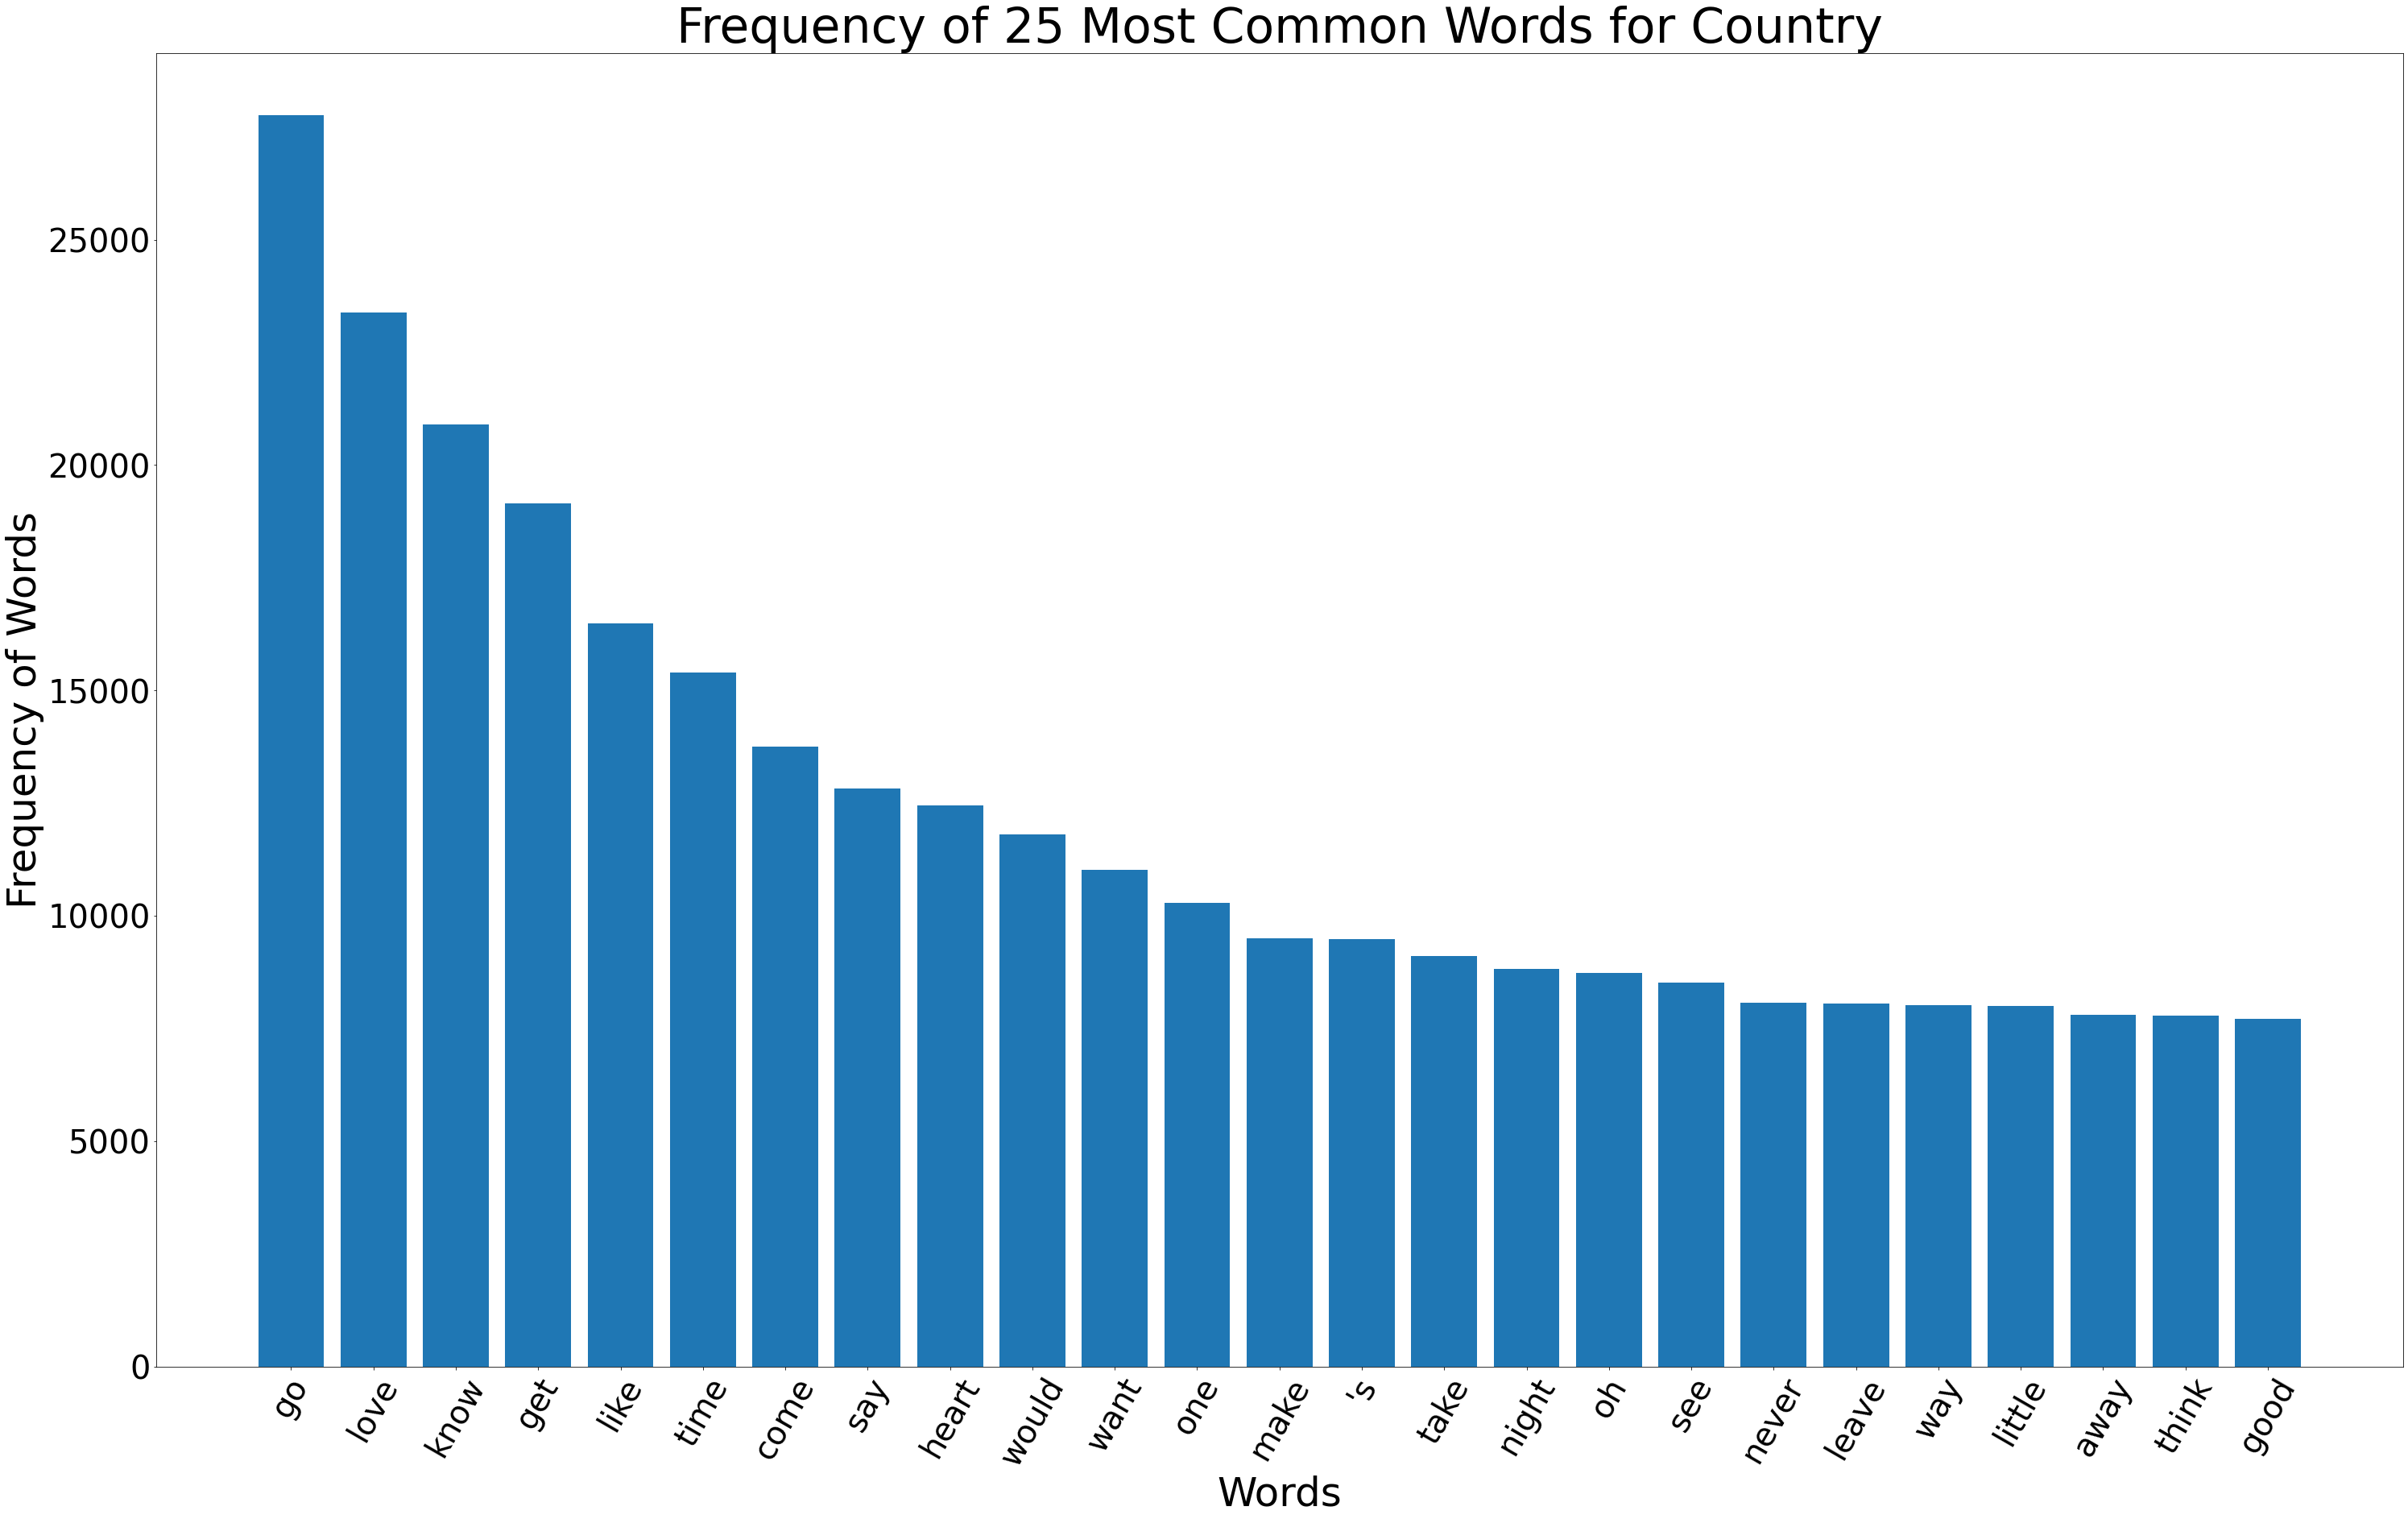

In [114]:
# Now we group by genre (top 25 words)
group_by = songs.groupby('genre')['lyrics_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))

def print_freq (genre):
    group_by_0 = group_by.loc[genre]
    words0 = list(zip(*group_by_0))[0]
    freq0 = list(zip(*group_by_0))[1]
    plt.figure(figsize=(50,30))
    plt.bar(words0, freq0)
    plt.xlabel('Words', fontsize=50)
    plt.ylabel('Frequency of Words', fontsize=50)
    plt.yticks(fontsize=40)
    plt.xticks(rotation=60, fontsize=40)
    plt.title(f'Frequency of 25 Most Common Words for {genre}', fontsize=60)
    plt.show()

print_freq('Country')

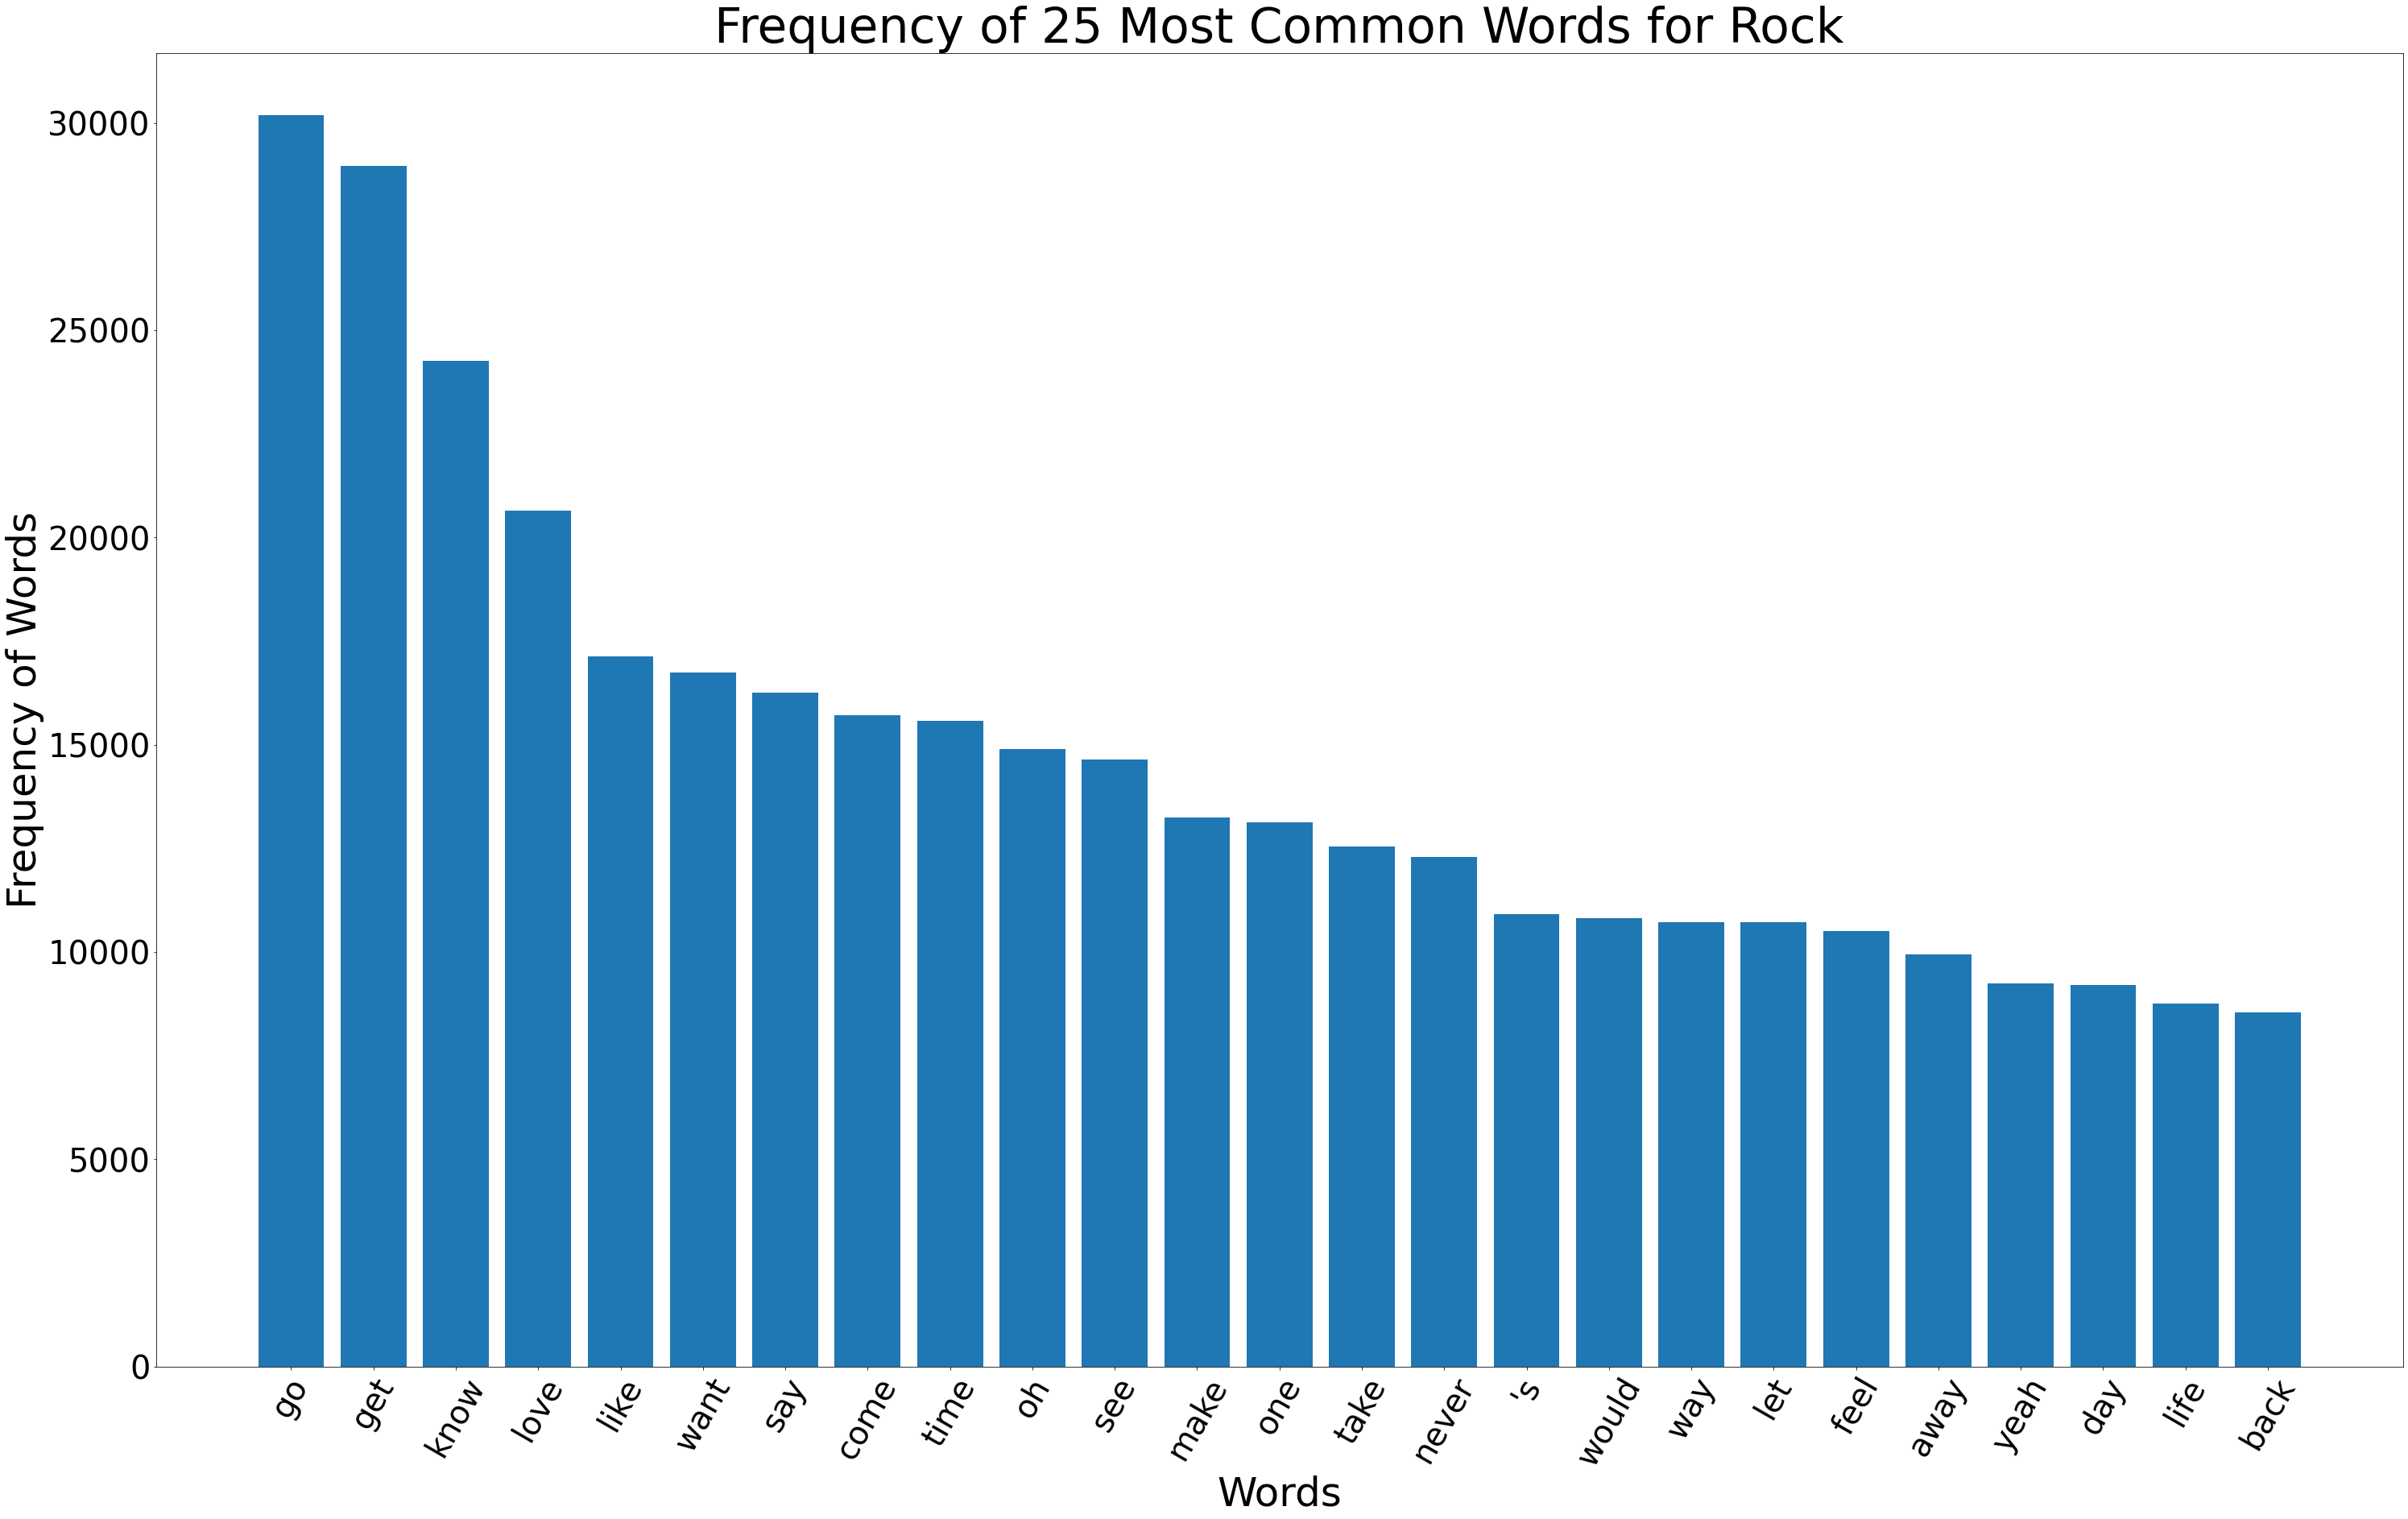

In [115]:
print_freq('Rock')

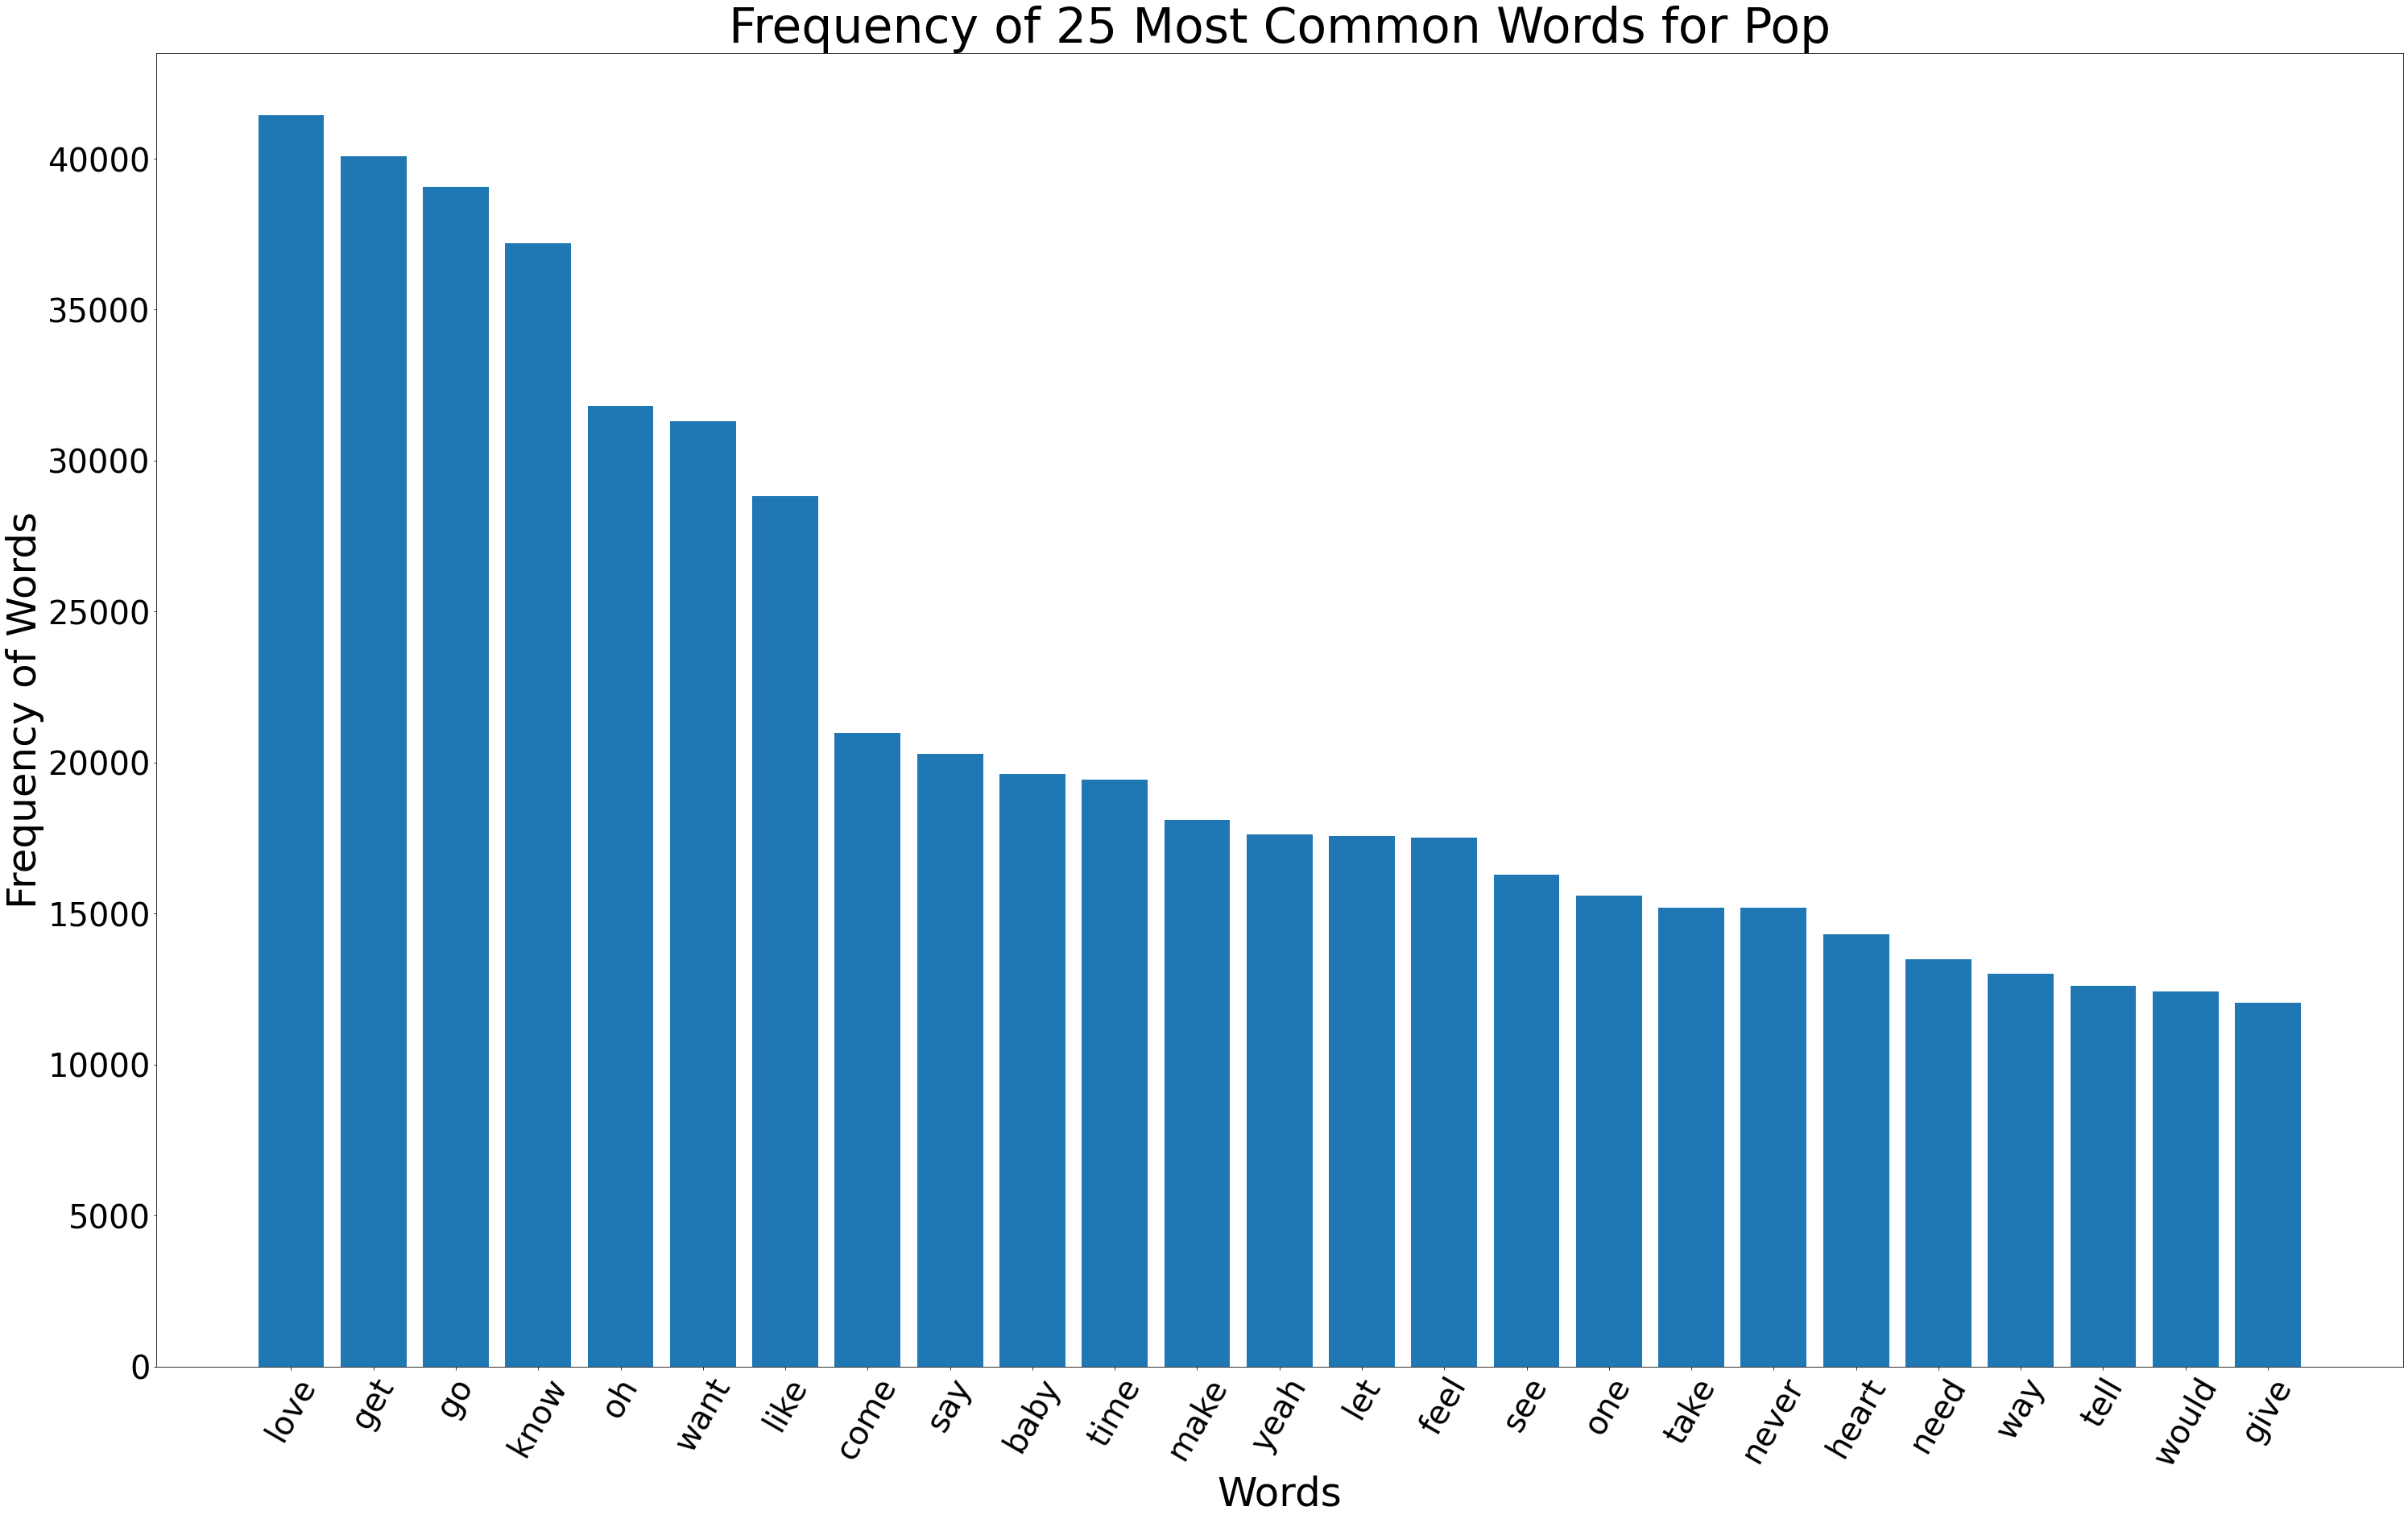

In [116]:
print_freq('Pop')

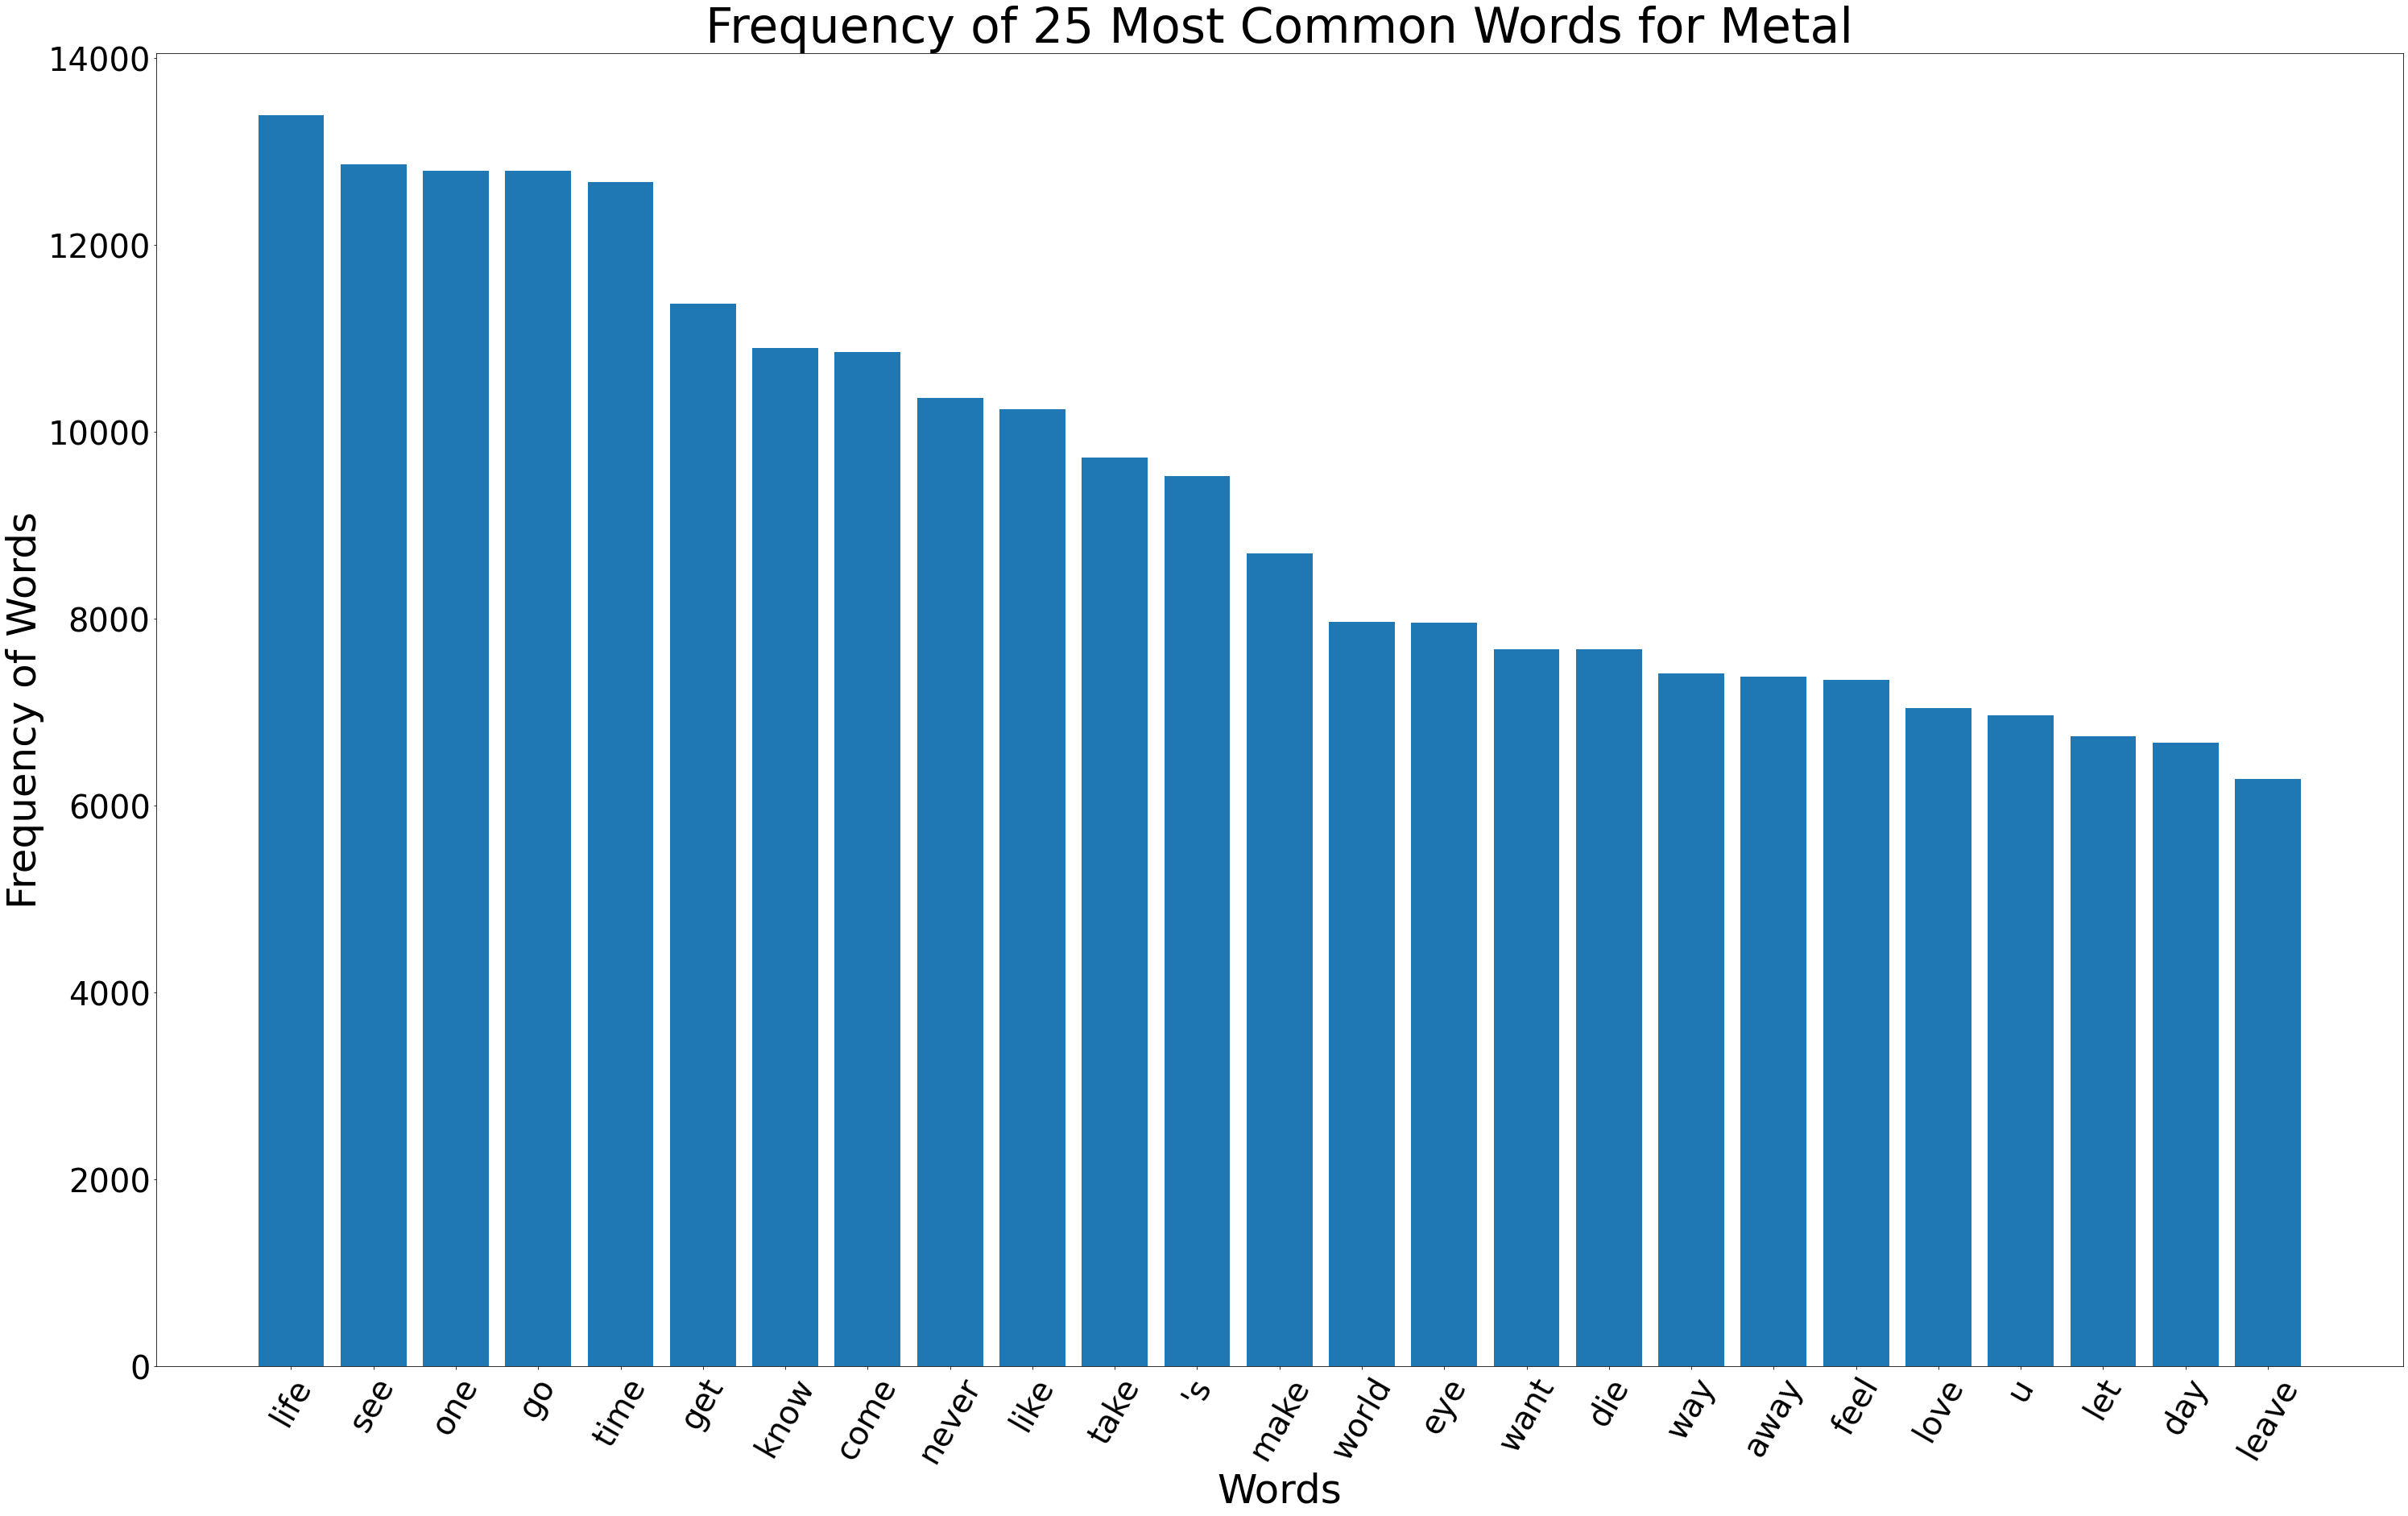

In [117]:
print_freq('Metal')

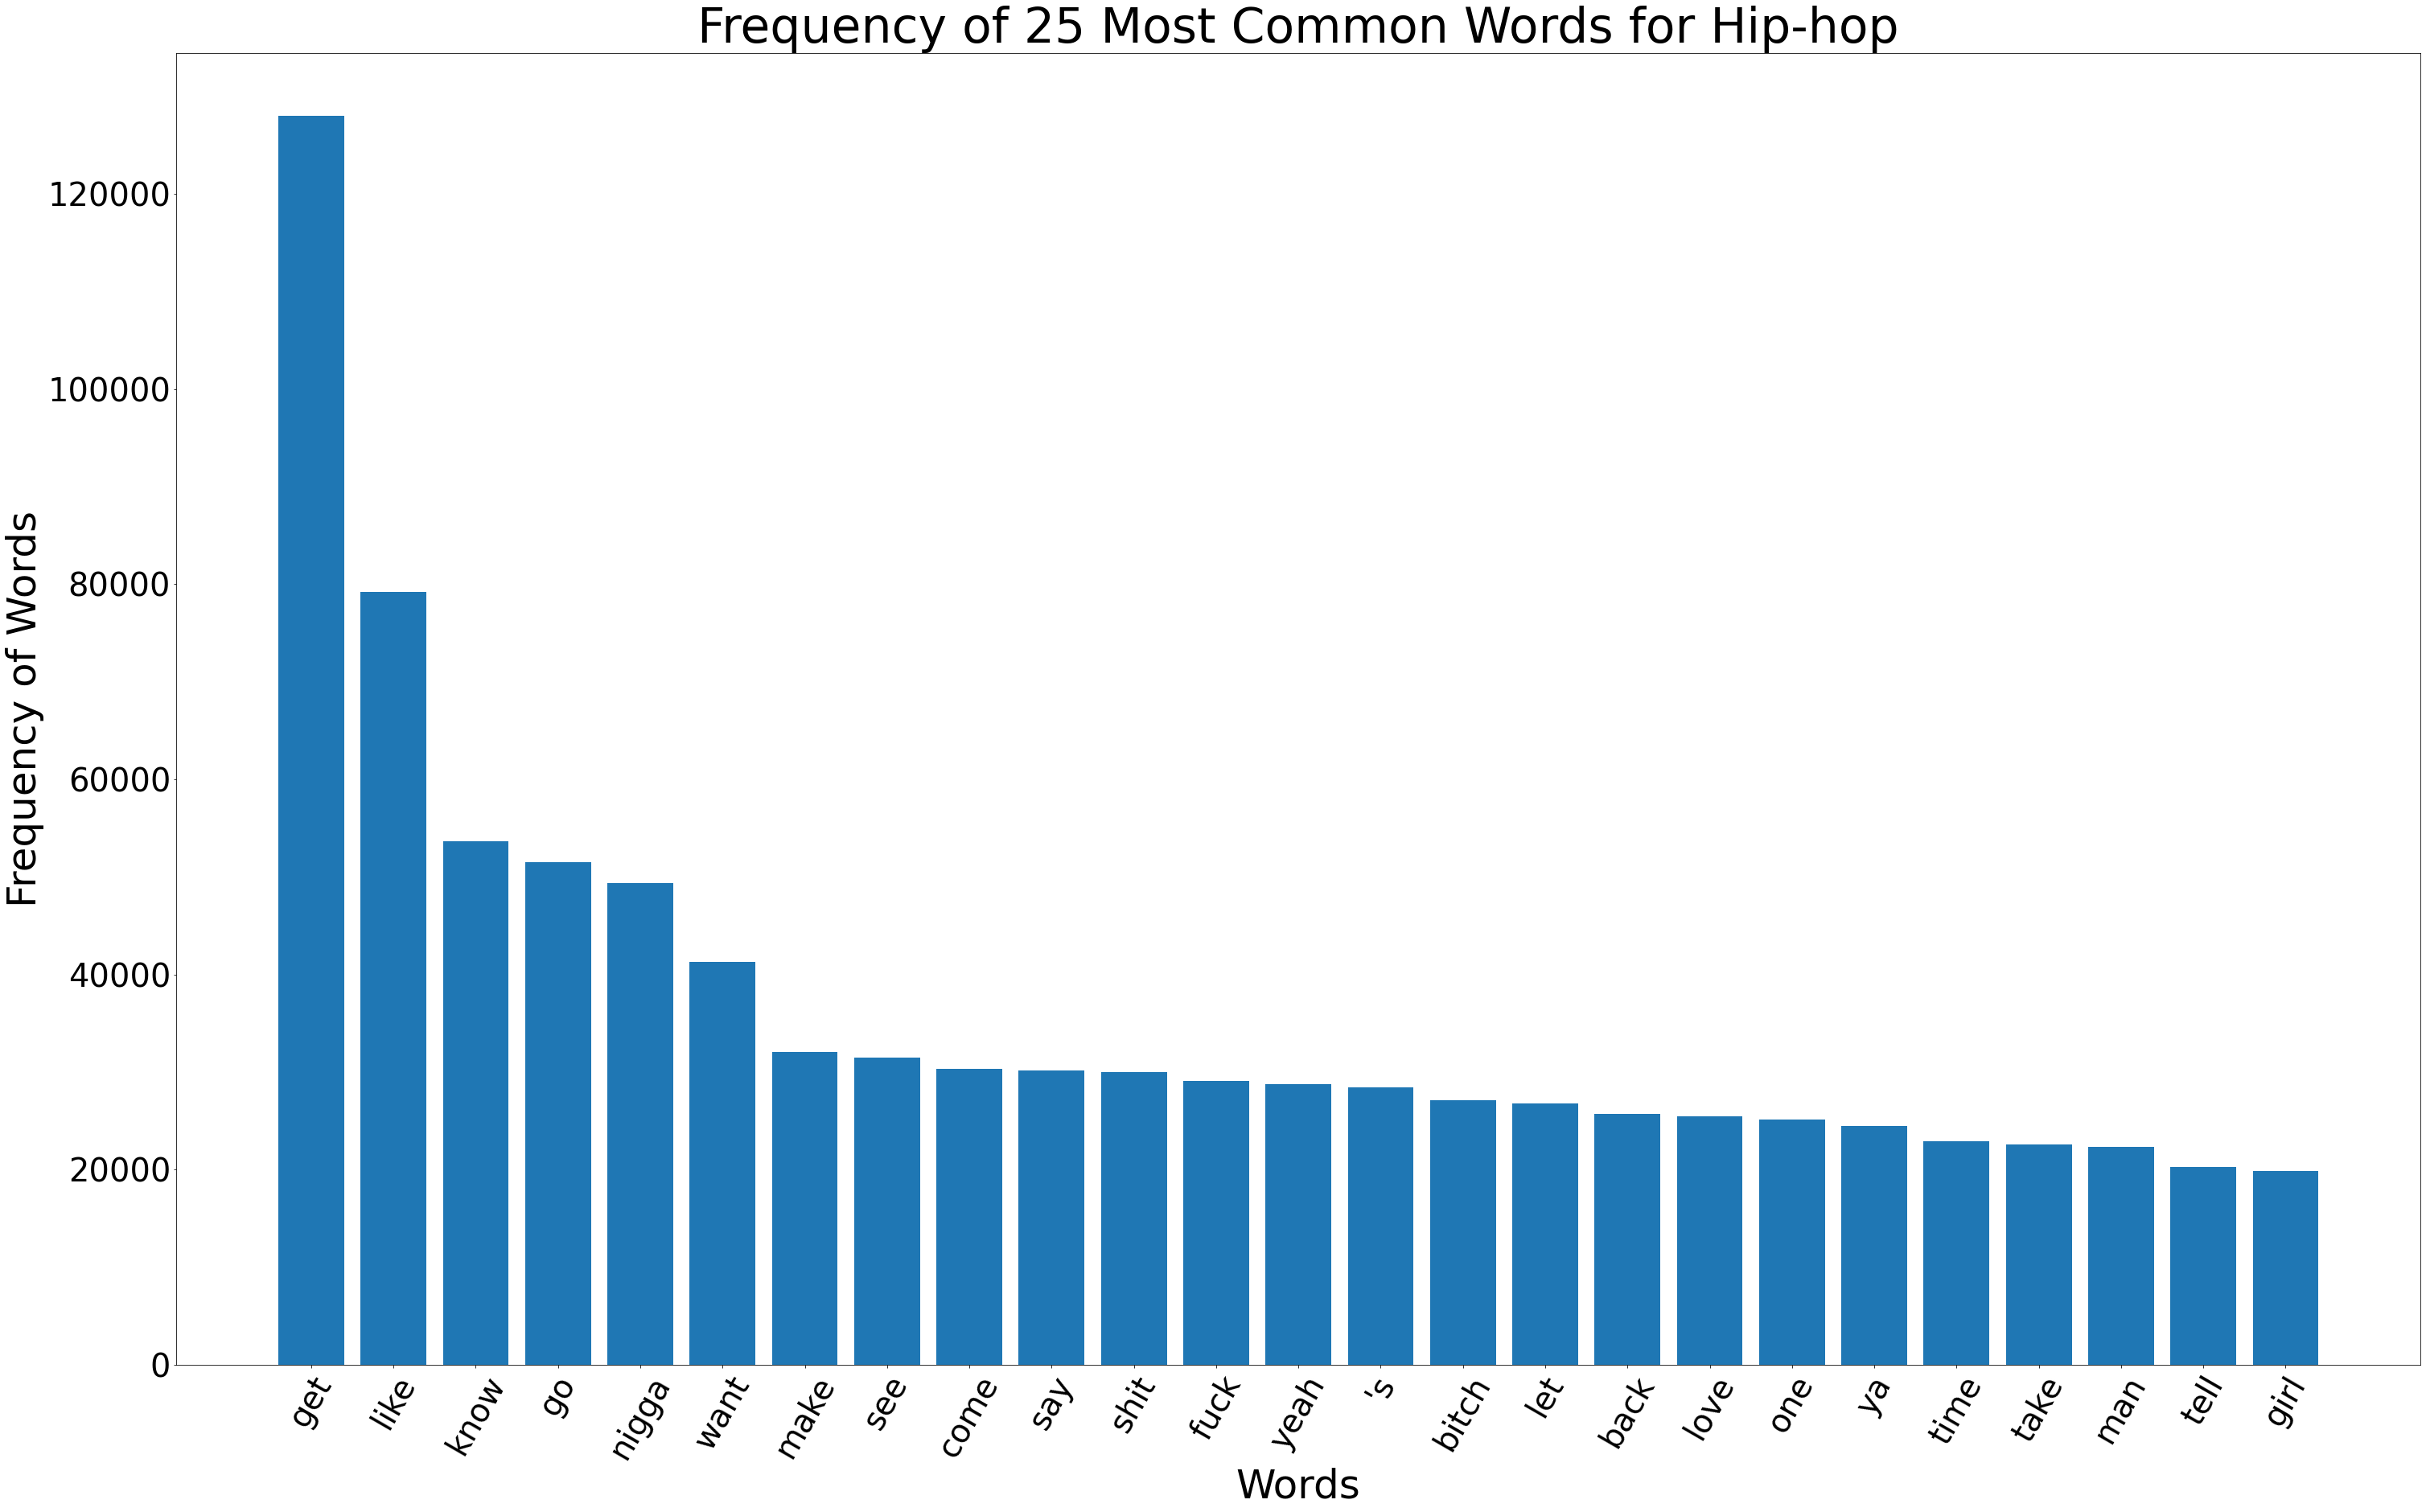

In [118]:
print_freq('Hip-hop')

## Topic Modeling 
The following methods are employed in this section: 

1. LDA (Latent Dirichlet Allocation) 
2. NMF (Non-Negative Matrix Factorization)

Both approaches yield different topic modeling, and below we explore the differences in their outputs. While there is significant overlap in the topics yielded, NMF is favored because the topics presented cover a broader range and are more distinct. In a problem like the one at hand, a more fine-tuned approach might be appropriate if topic modeling were the objective of the project. For instance, modeling could be genre specific in addition to global.

In [127]:
#In order to get started with modeling tasks, we first have to vectorize our lyrics. Some of the steps that follow 
#are adapted from: https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d

# LDA requires having prepared a document term matrix, which provides word counts for each document:

tf_vectorizer = CountVectorizer(max_df=0.85, min_df=100, max_features=2000) #max_df removes words that appear in n% of lyrics
tf = tf_vectorizer.fit_transform(songs['lyrics_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

,10,100,12,20,2x,30,40,50,able,accept,...,yes,yesterday,yet,yo,york,young,youth,yuh,zero,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92502,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
92503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
# LDA modeling
lda_model = LatentDirichletAllocation(n_components=7, learning_method='online', 
                                      max_iter=100, random_state=0).fit(tf)
no_top_words = 10

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
time know never life would go away see heart one
Topic 1:
get nigga fuck shit bitch ya money yo back man
Topic 2:
oh yeah baby hey ooh na da ah uh come
Topic 3:
love night come home day la long tonight go sing
Topic 4:
get go want know say let girl make good baby
Topic 5:
god die soul blood world burn life one fire death
Topic 6:
like rock play roll make head beat come get stop


## Topic modeling: Interpretation for LDA

As the outputs above show, the result of topic modeling requires subjective interpretation. Below are paraphrased summaries for each of the topics.

Topic 0: Life, love, longing.

Topic 1: Money and hustling.

Topic 2: Love and sexuality.

Topic 3: Love and fun.

Topic 4: Affection, women.

Topic 5: Death, faith.

Topic 6: Dance.


In [129]:
# NMF modeling relies on a TF-IDF (term frequency-inverse document frequency) representation of our corpus.
# As an initial step we create a TF-IDF matrix.

tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=100, max_features=2000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(songs['lyrics_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

,10,100,12,20,2x,30,40,50,able,accept,...,yes,yesterday,yet,yo,york,young,youth,yuh,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.071589,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
# Displaying NMF-produced topics
nmf = NMF(n_components=7, random_state=0, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
life world fall heart eye dream die come light away
Topic 1:
get nigga like shit fuck bitch ya yo money man
Topic 2:
go get let home come away back long take time
Topic 3:
love heart give true make sweet hold always fall forever
Topic 4:
oh yeah ooh whoa baby hey ah la uh yes
Topic 5:
want baby girl know yeah need get feel like right
Topic 6:
know would say never could time think one way thing


## Topic modeling: Interpretation for NMF

As with LDA, NMF outputs require subjective interpretation. Below are paraphrased summaries for each of the topics.

Topic 0: Life as a journey.

Topic 1: Money and hustling.

Topic 2: Home and longing.

Topic 3: Love and life.

Topic 4: Love and fun.

Topic 5: Love and sexuality.

Topic 6: Introspection and time.


In [131]:
# Adding NMF and LDA topics to data frame
nmf_topic_values = nmf.transform(tfidf)
songs['nmf_topics'] = nmf_topic_values.argmax(axis=1)
lda_topic_values = lda_model.transform(tf)
songs['lda_topics'] = lda_topic_values.argmax(axis=1)

In [132]:
songs.to_csv('data/lemmatized_lyrics.csv', index=False)

In [142]:
# Remapping LDA topic numbers to subjective renaming in order to ease interpretation
nmf_remap = {0: 'Life as a journey', 1: 'Money and hustling', 2: 'Home and longing', 3: 'Love and life',
             4: 'Love and fun', 5: 'Love and sexuality', 6: 'Introspection and time'}

songs['nmf_topics'] = songs['nmf_topics'].map(nmf_remap)

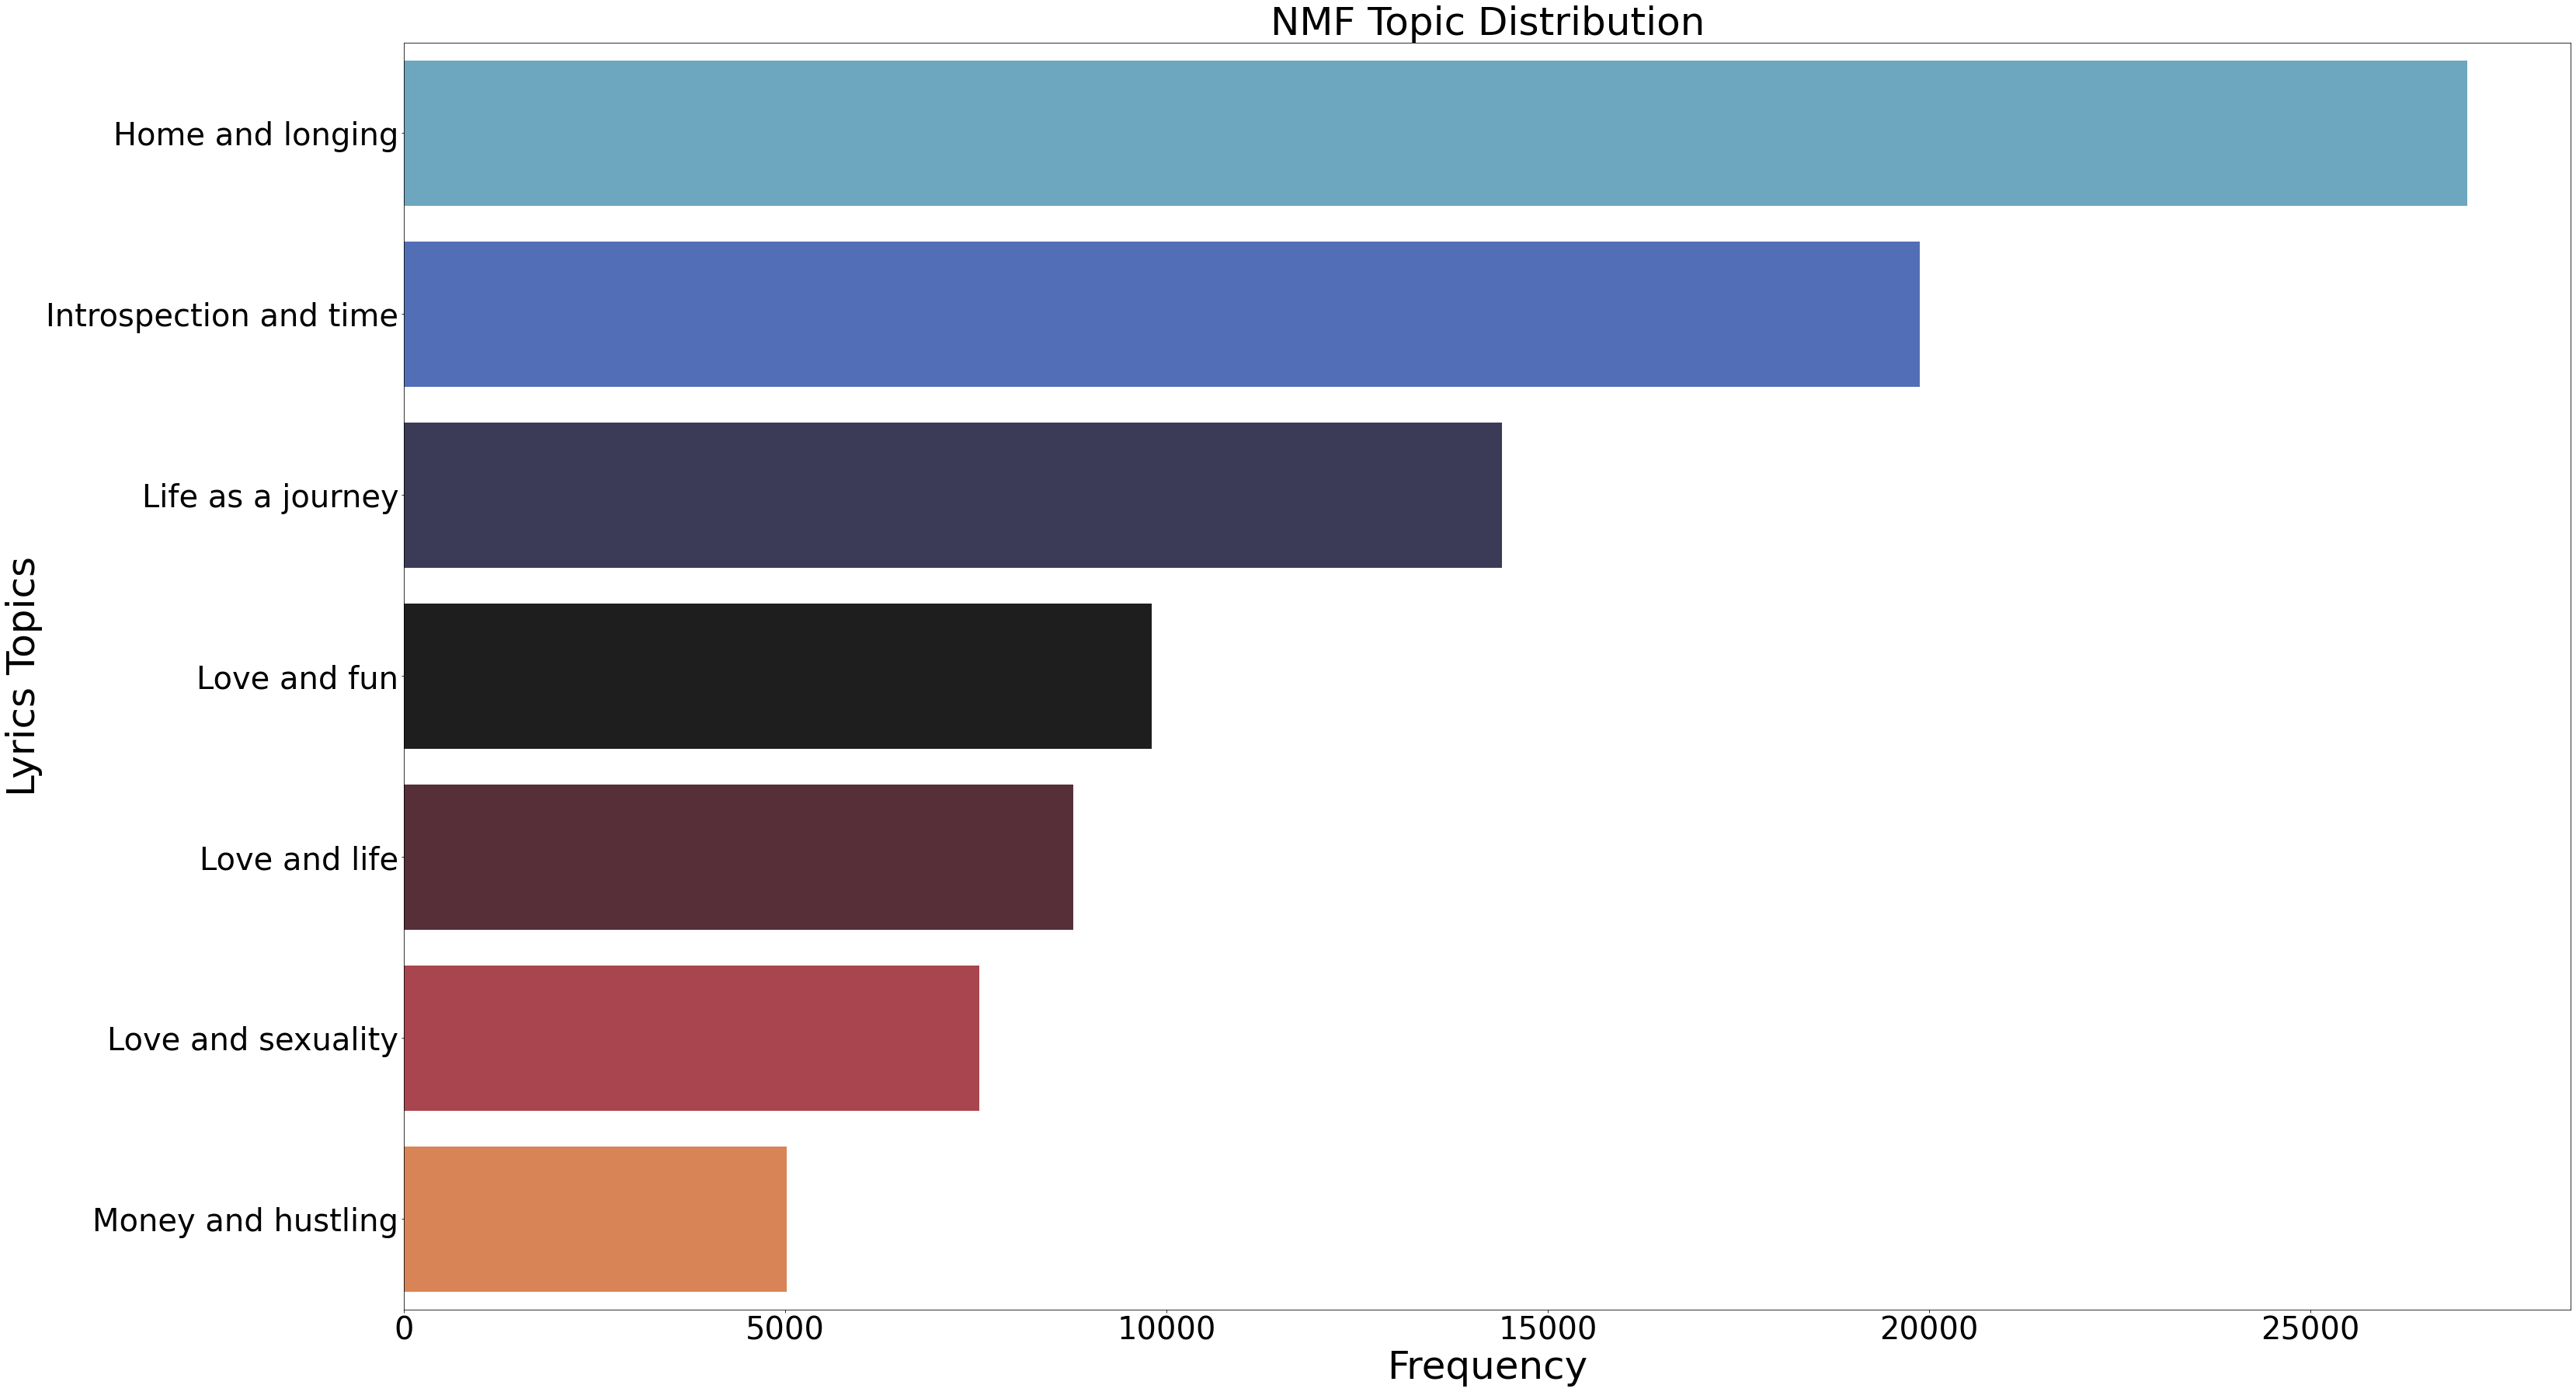

In [143]:
# LDA topic distribution across all genres

nmf_x = songs['nmf_topics'].value_counts()
nmf_y = nmf_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x=nmf_x, y=nmf_y.index, palette='icefire')
plt.title("NMF Topic Distribution", fontsize=50)
plt.ylabel('Lyrics Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)
plt.show()

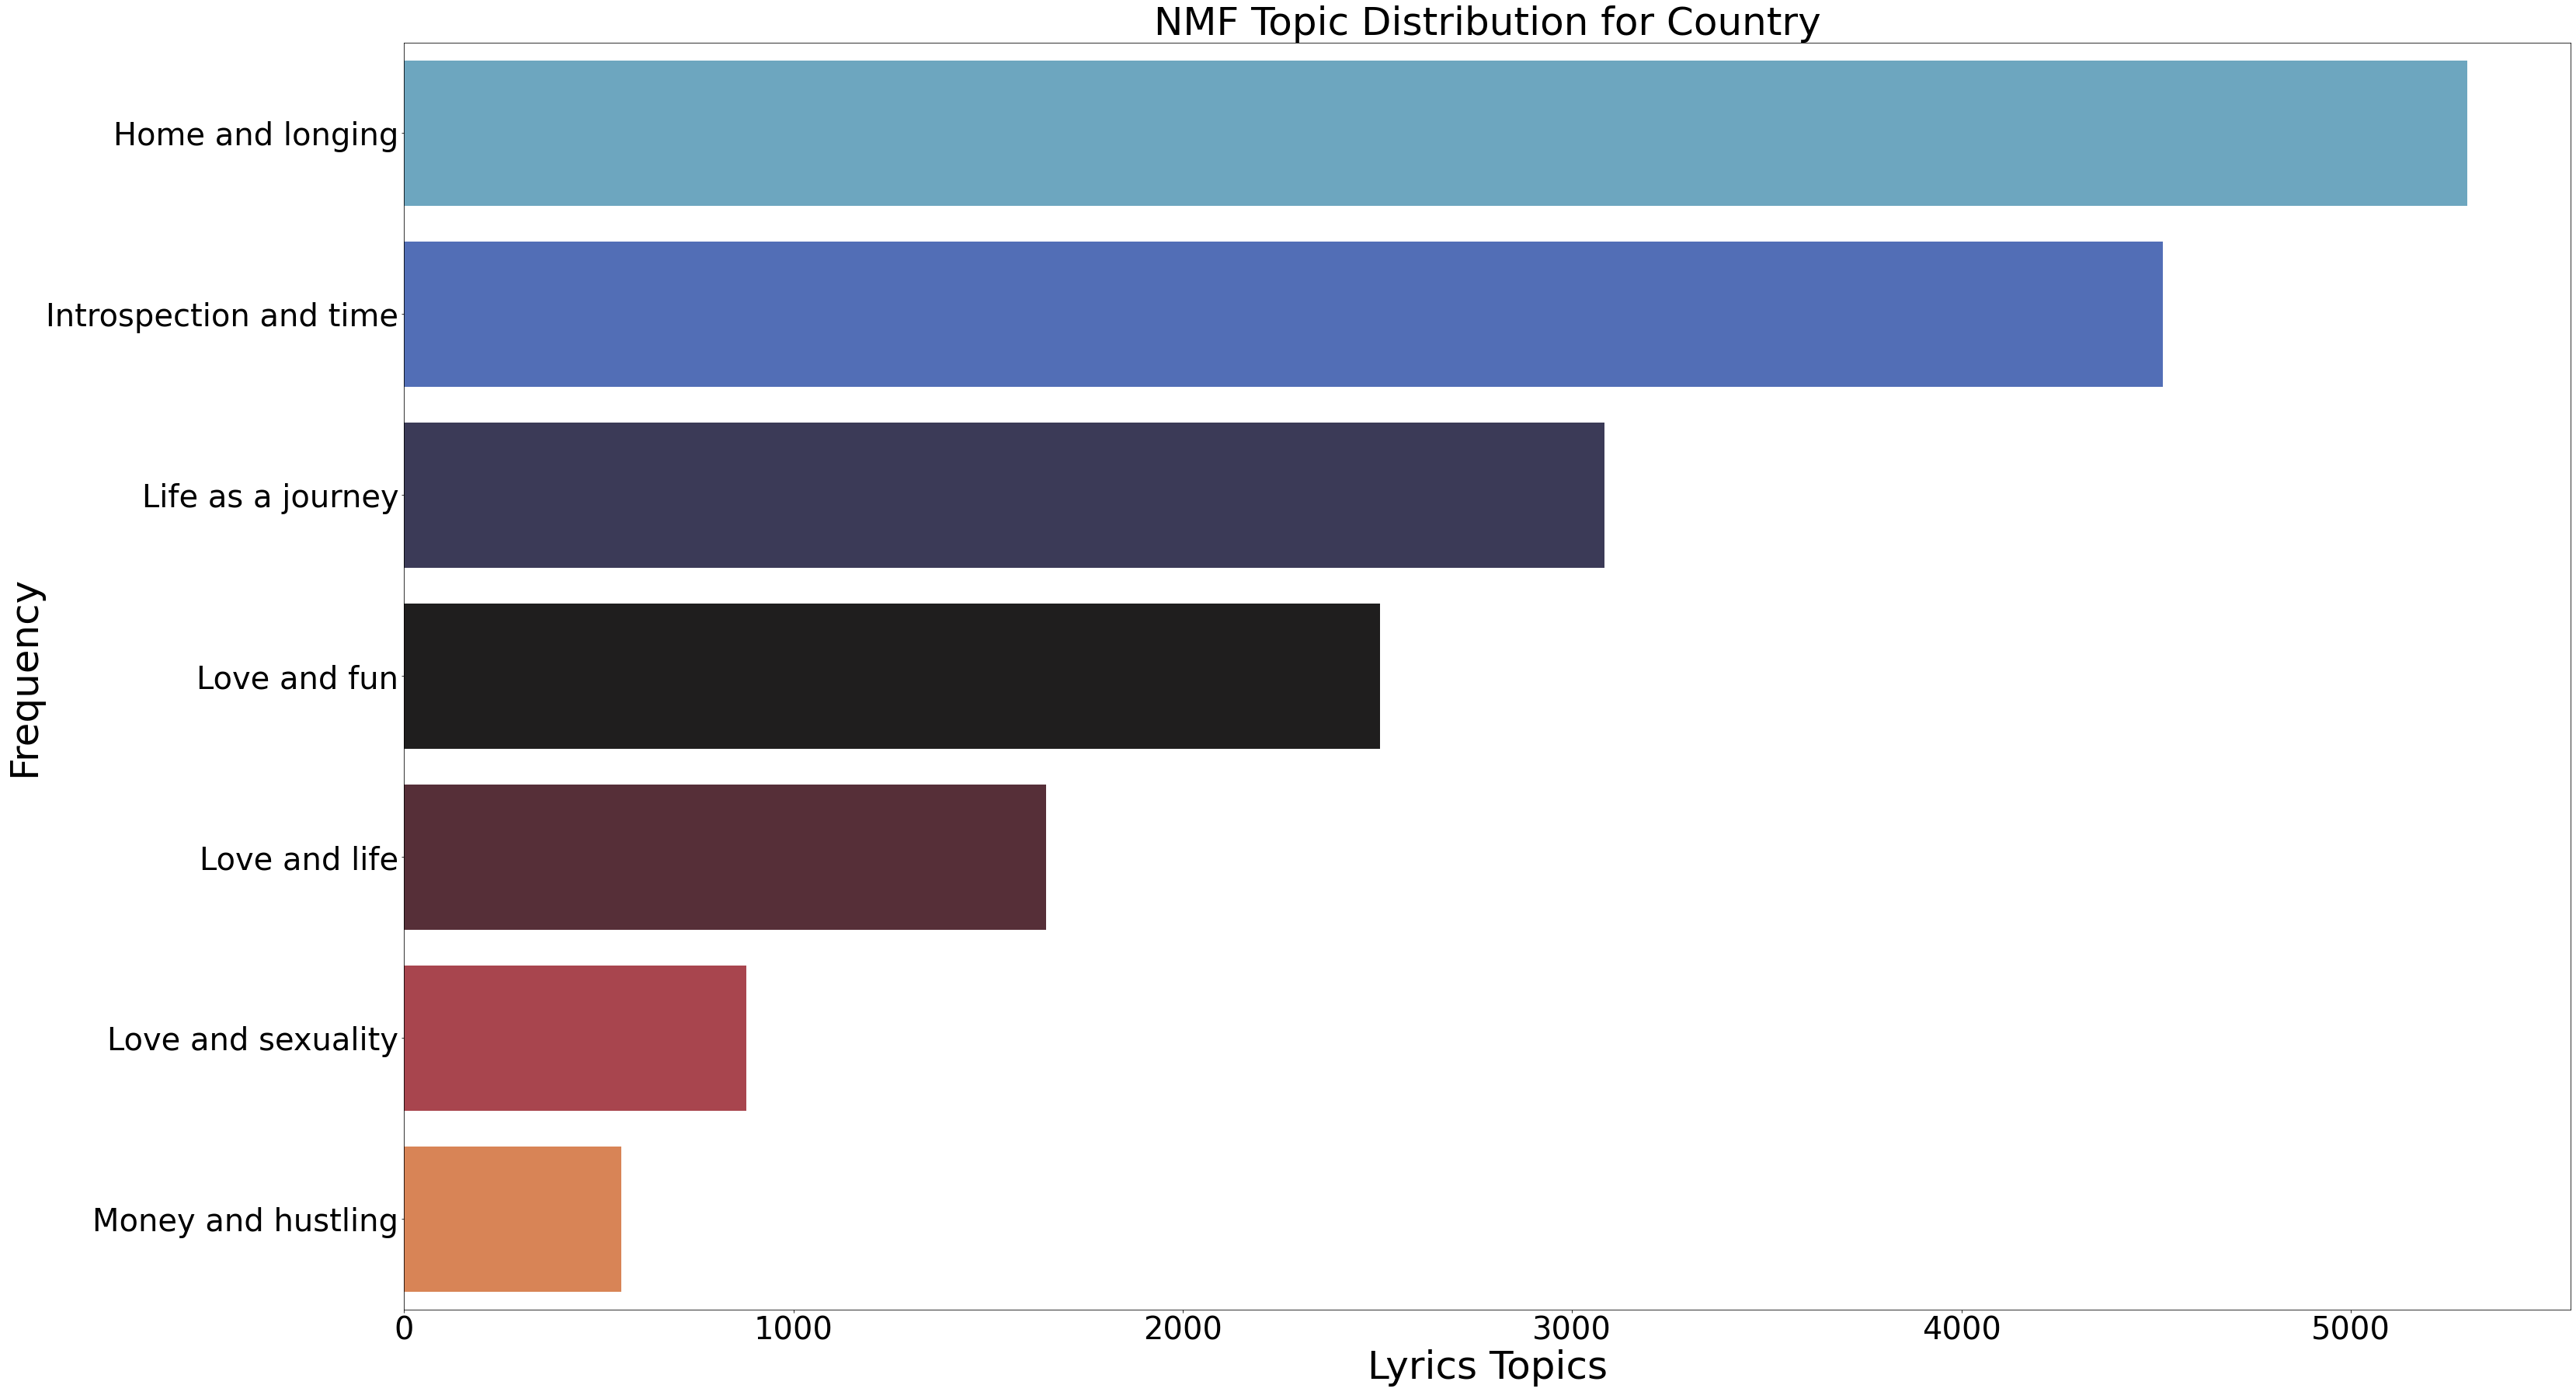

In [144]:
# LDA topic distributions per genre

# We first create a function that we will call per genre

def display_genre_topics(genre): 
    df_genre = songs.loc[(songs['genre']==genre)]
    x = df_genre['nmf_topics'].value_counts()
    y = x.sort_index()
    plt.figure(figsize=(50,30))
    sns.barplot(x=x, y=y.index, palette='icefire')
    plt.title(f"NMF Topic Distribution for {genre}", fontsize=50)
    plt.ylabel('Frequency', fontsize=50)
    plt.yticks(fontsize=40)
    plt.xlabel('Lyrics Topics', fontsize=50)
    plt.xticks(fontsize=40)
    
display_genre_topics('Country')

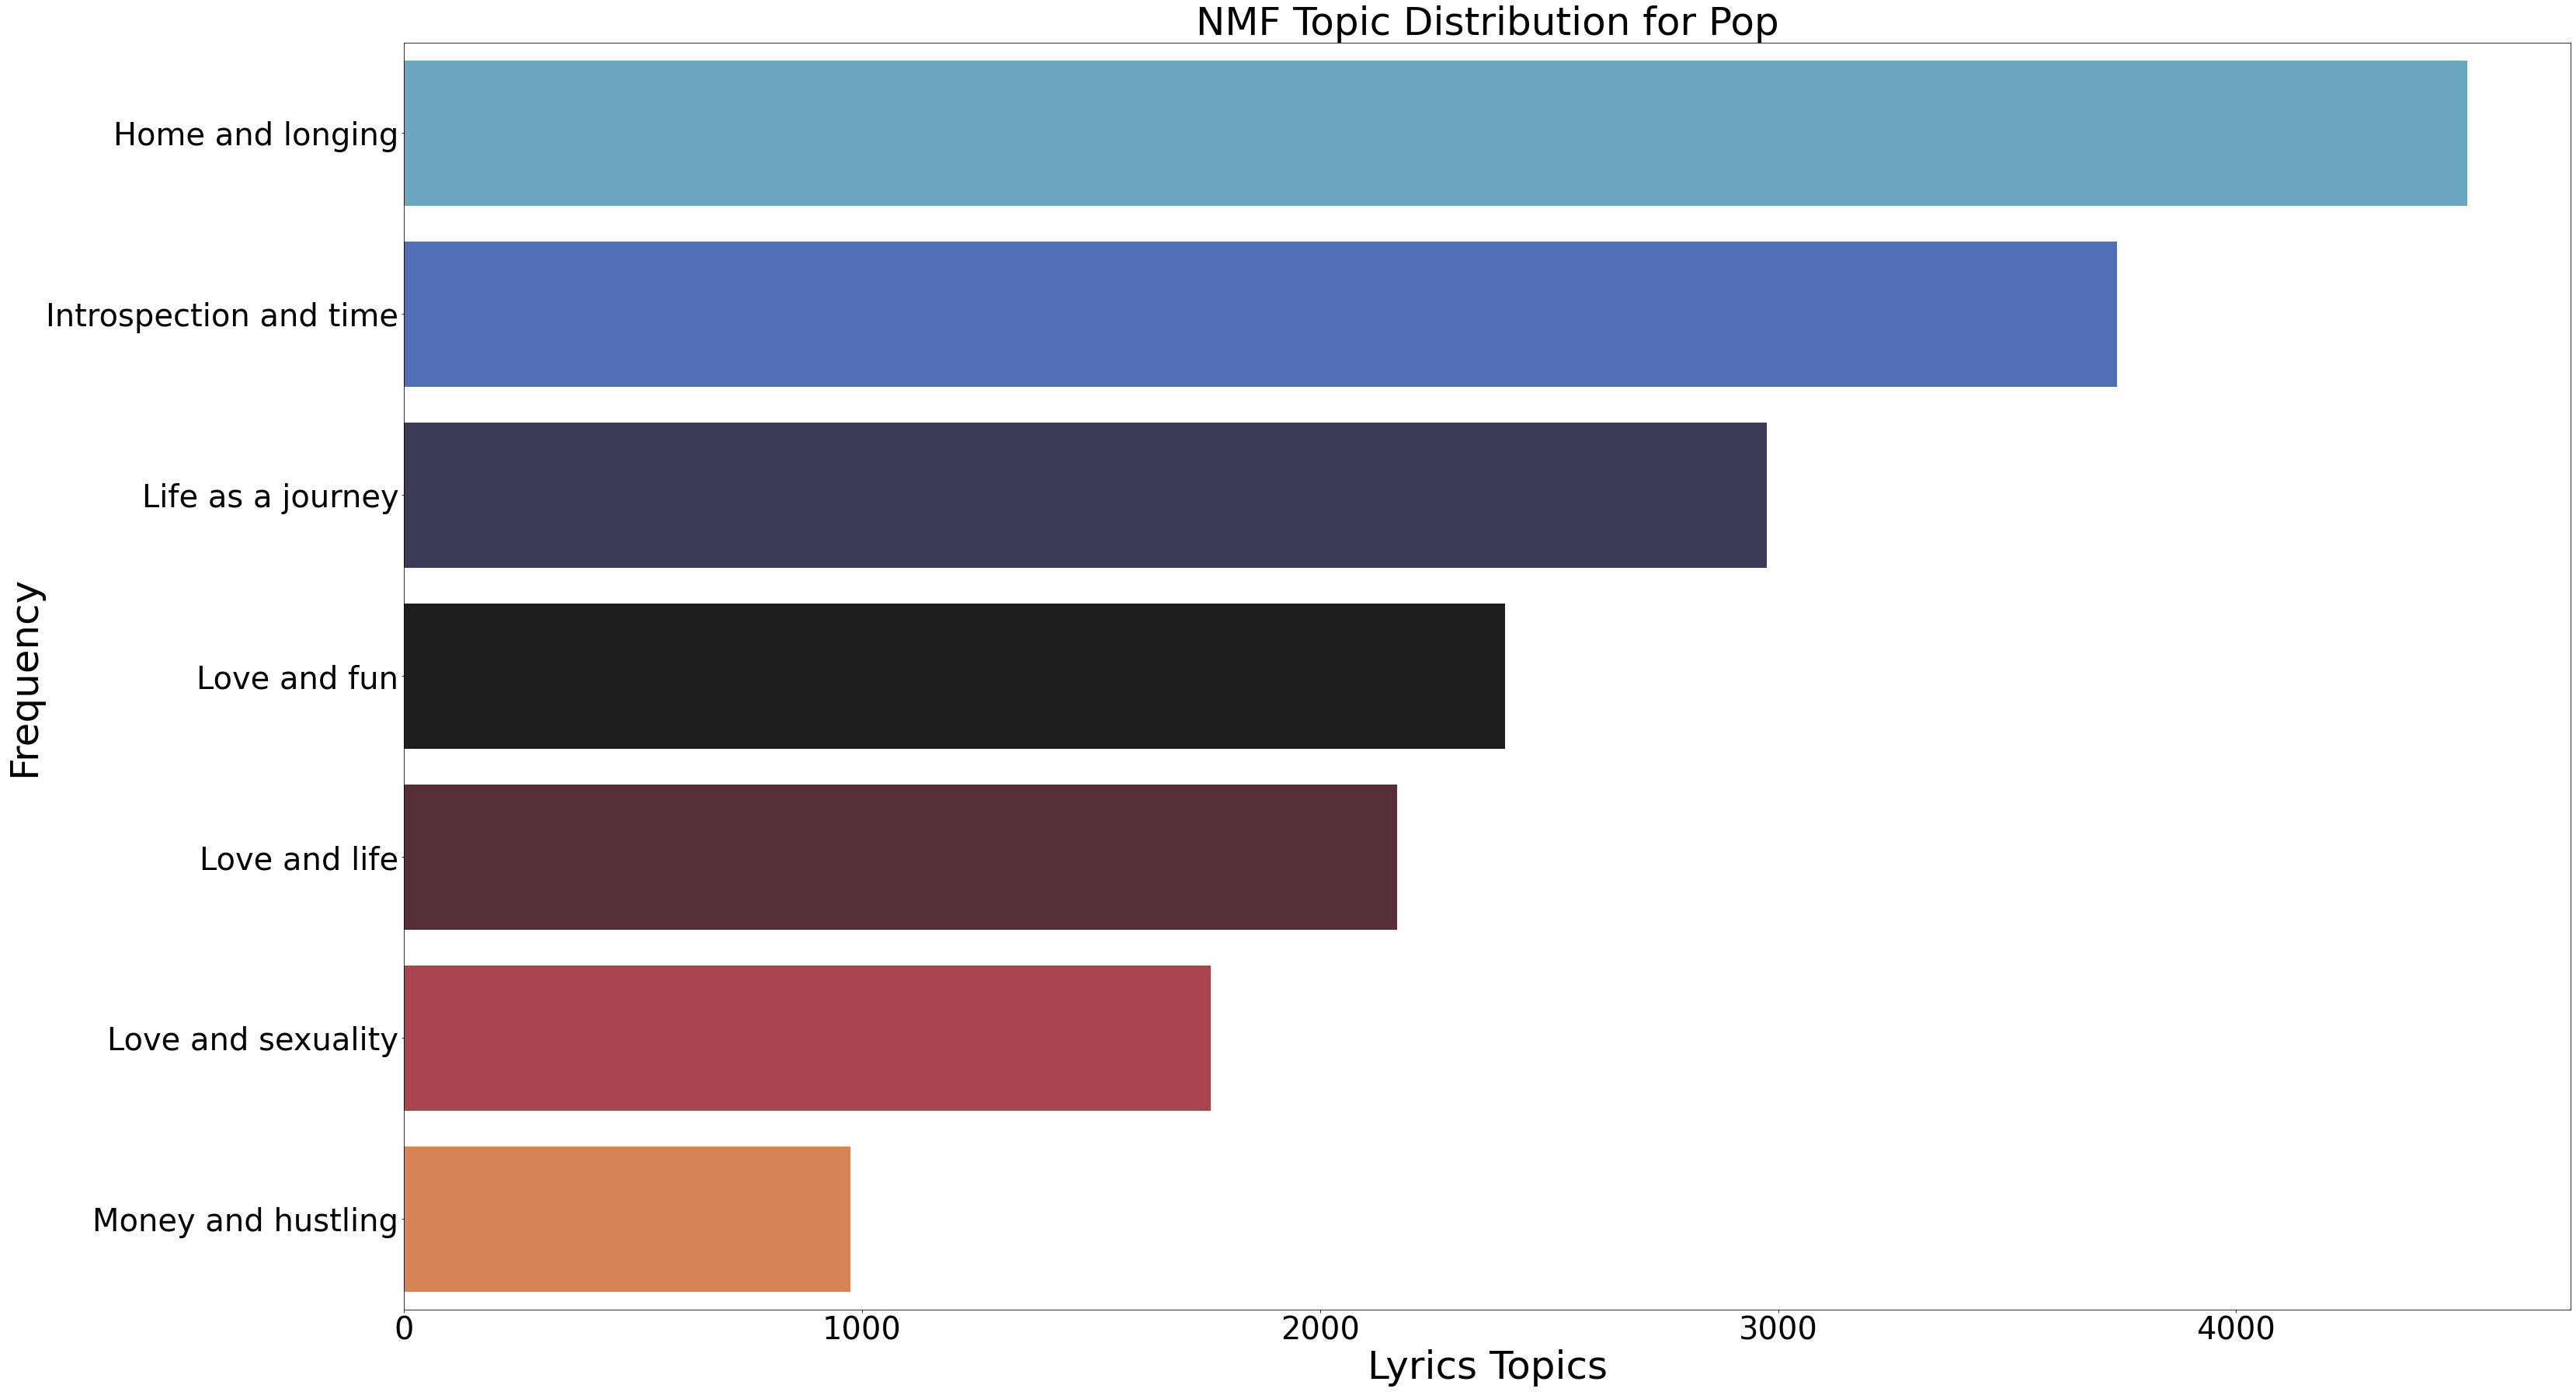

In [145]:
display_genre_topics('Pop')

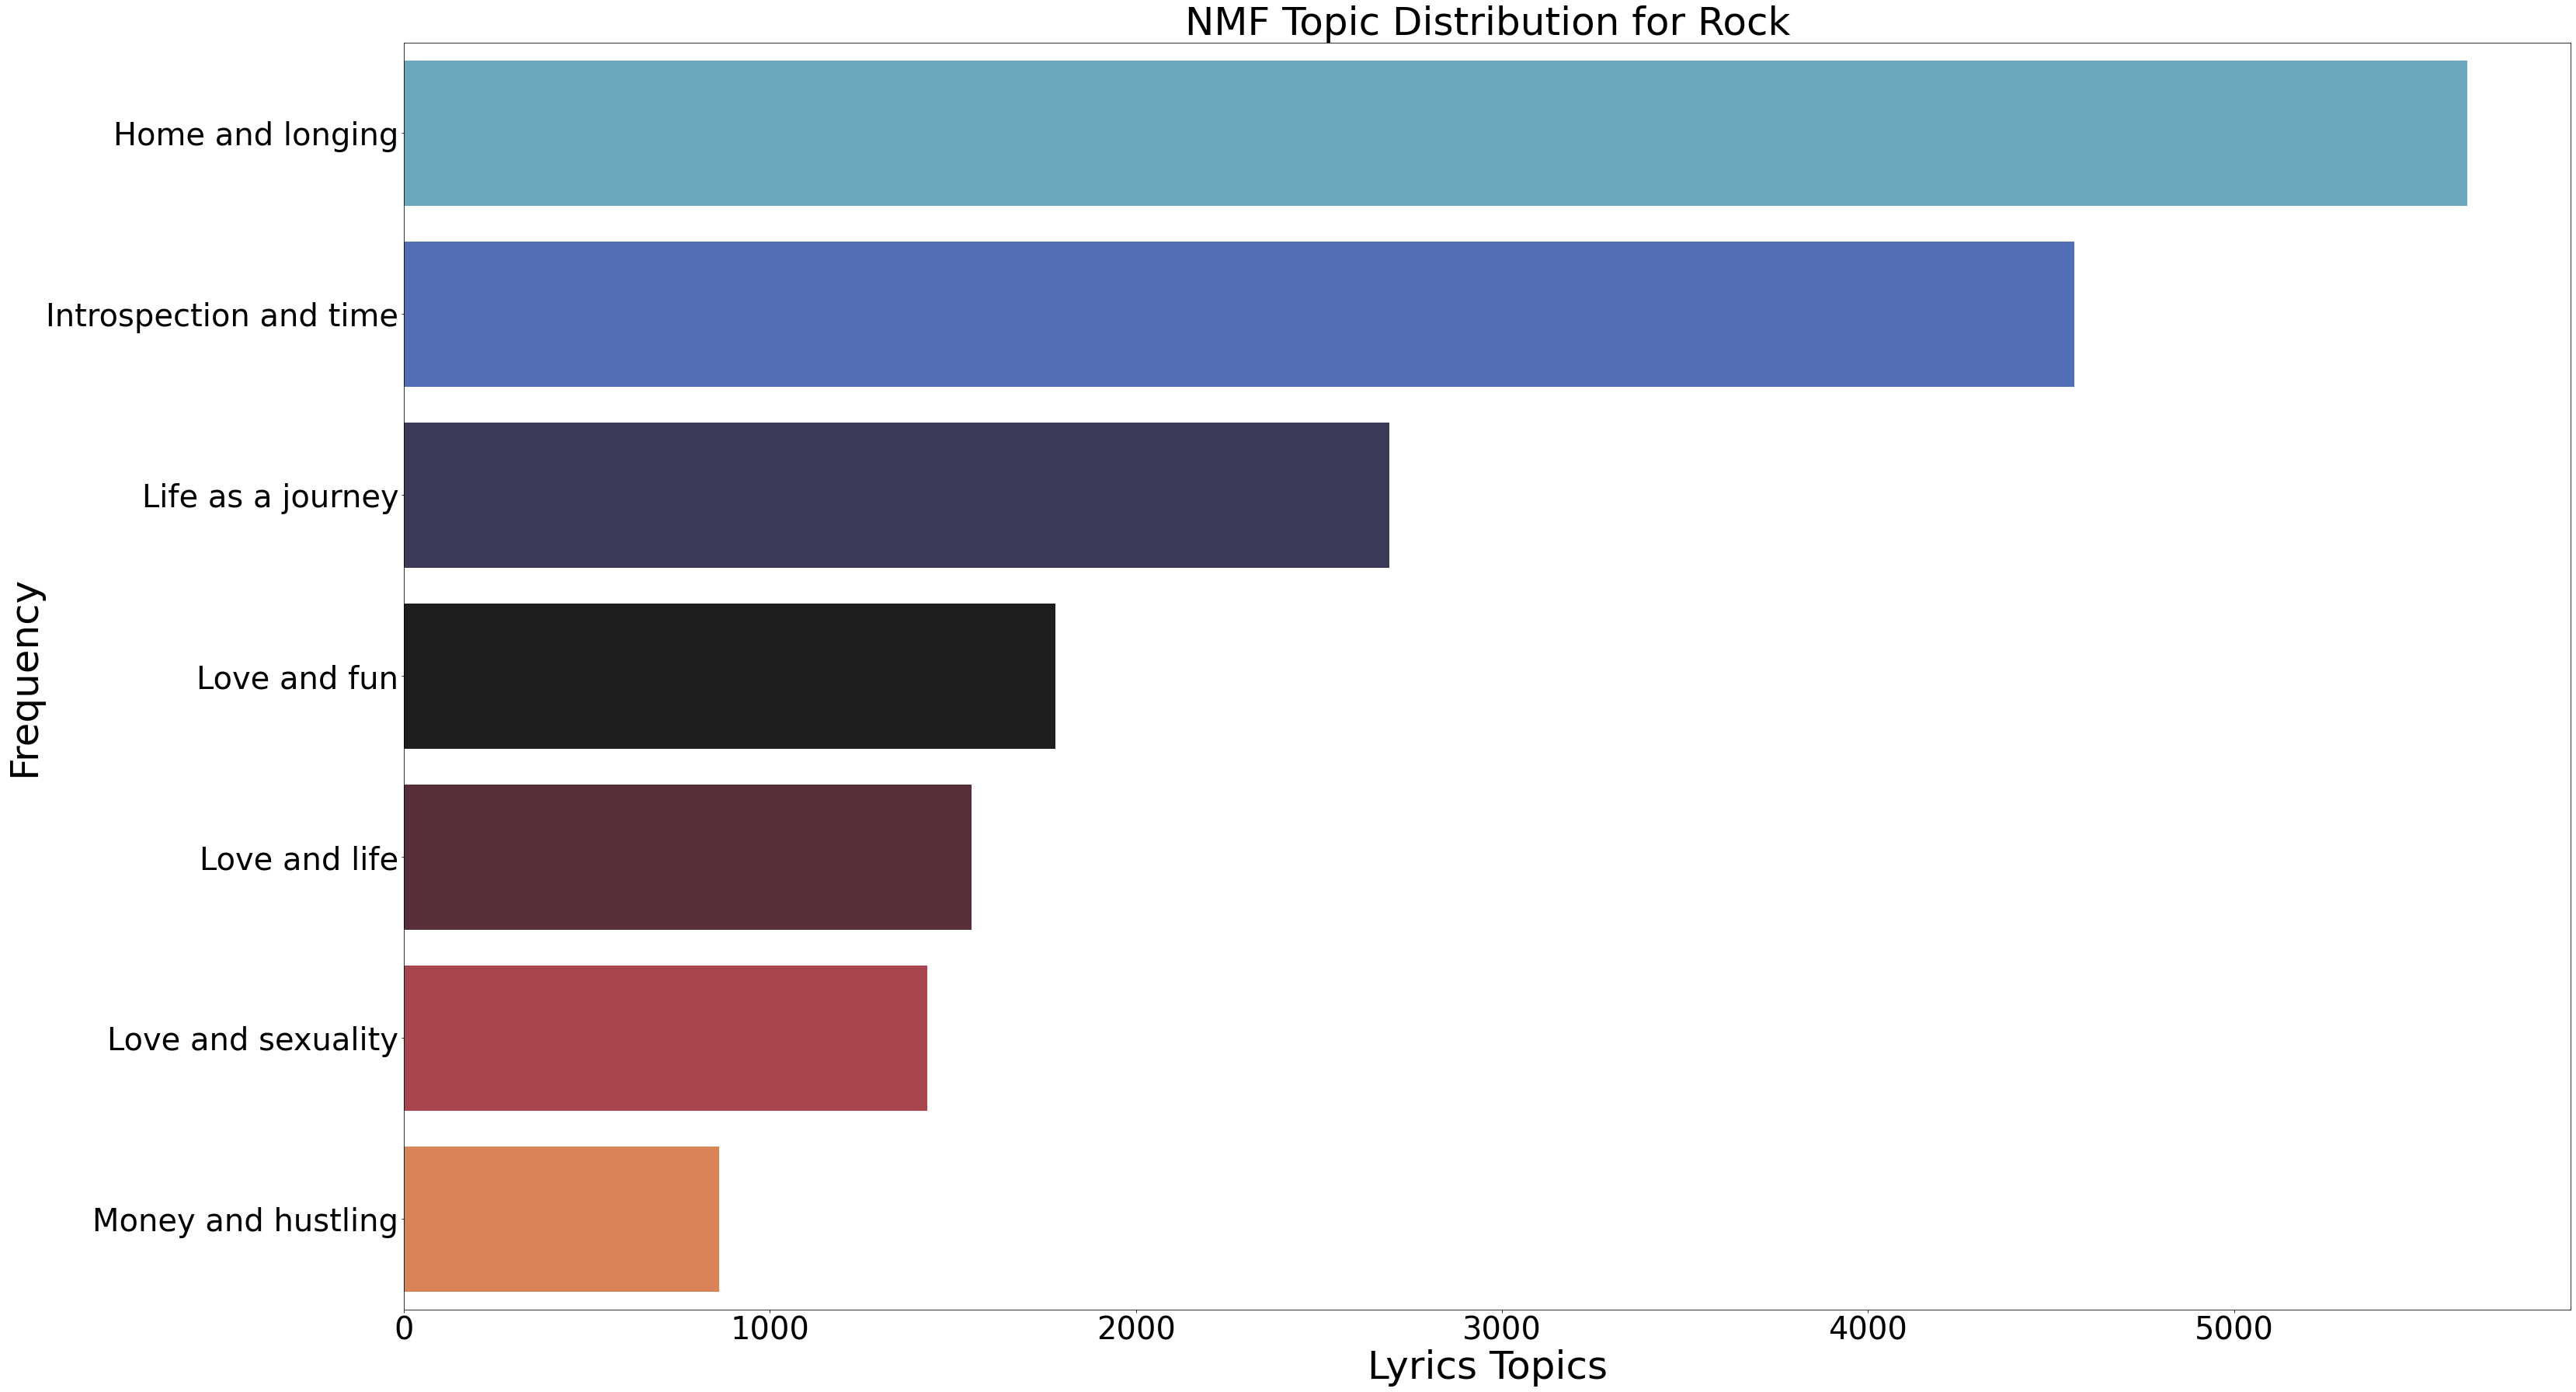

In [146]:
display_genre_topics('Rock')

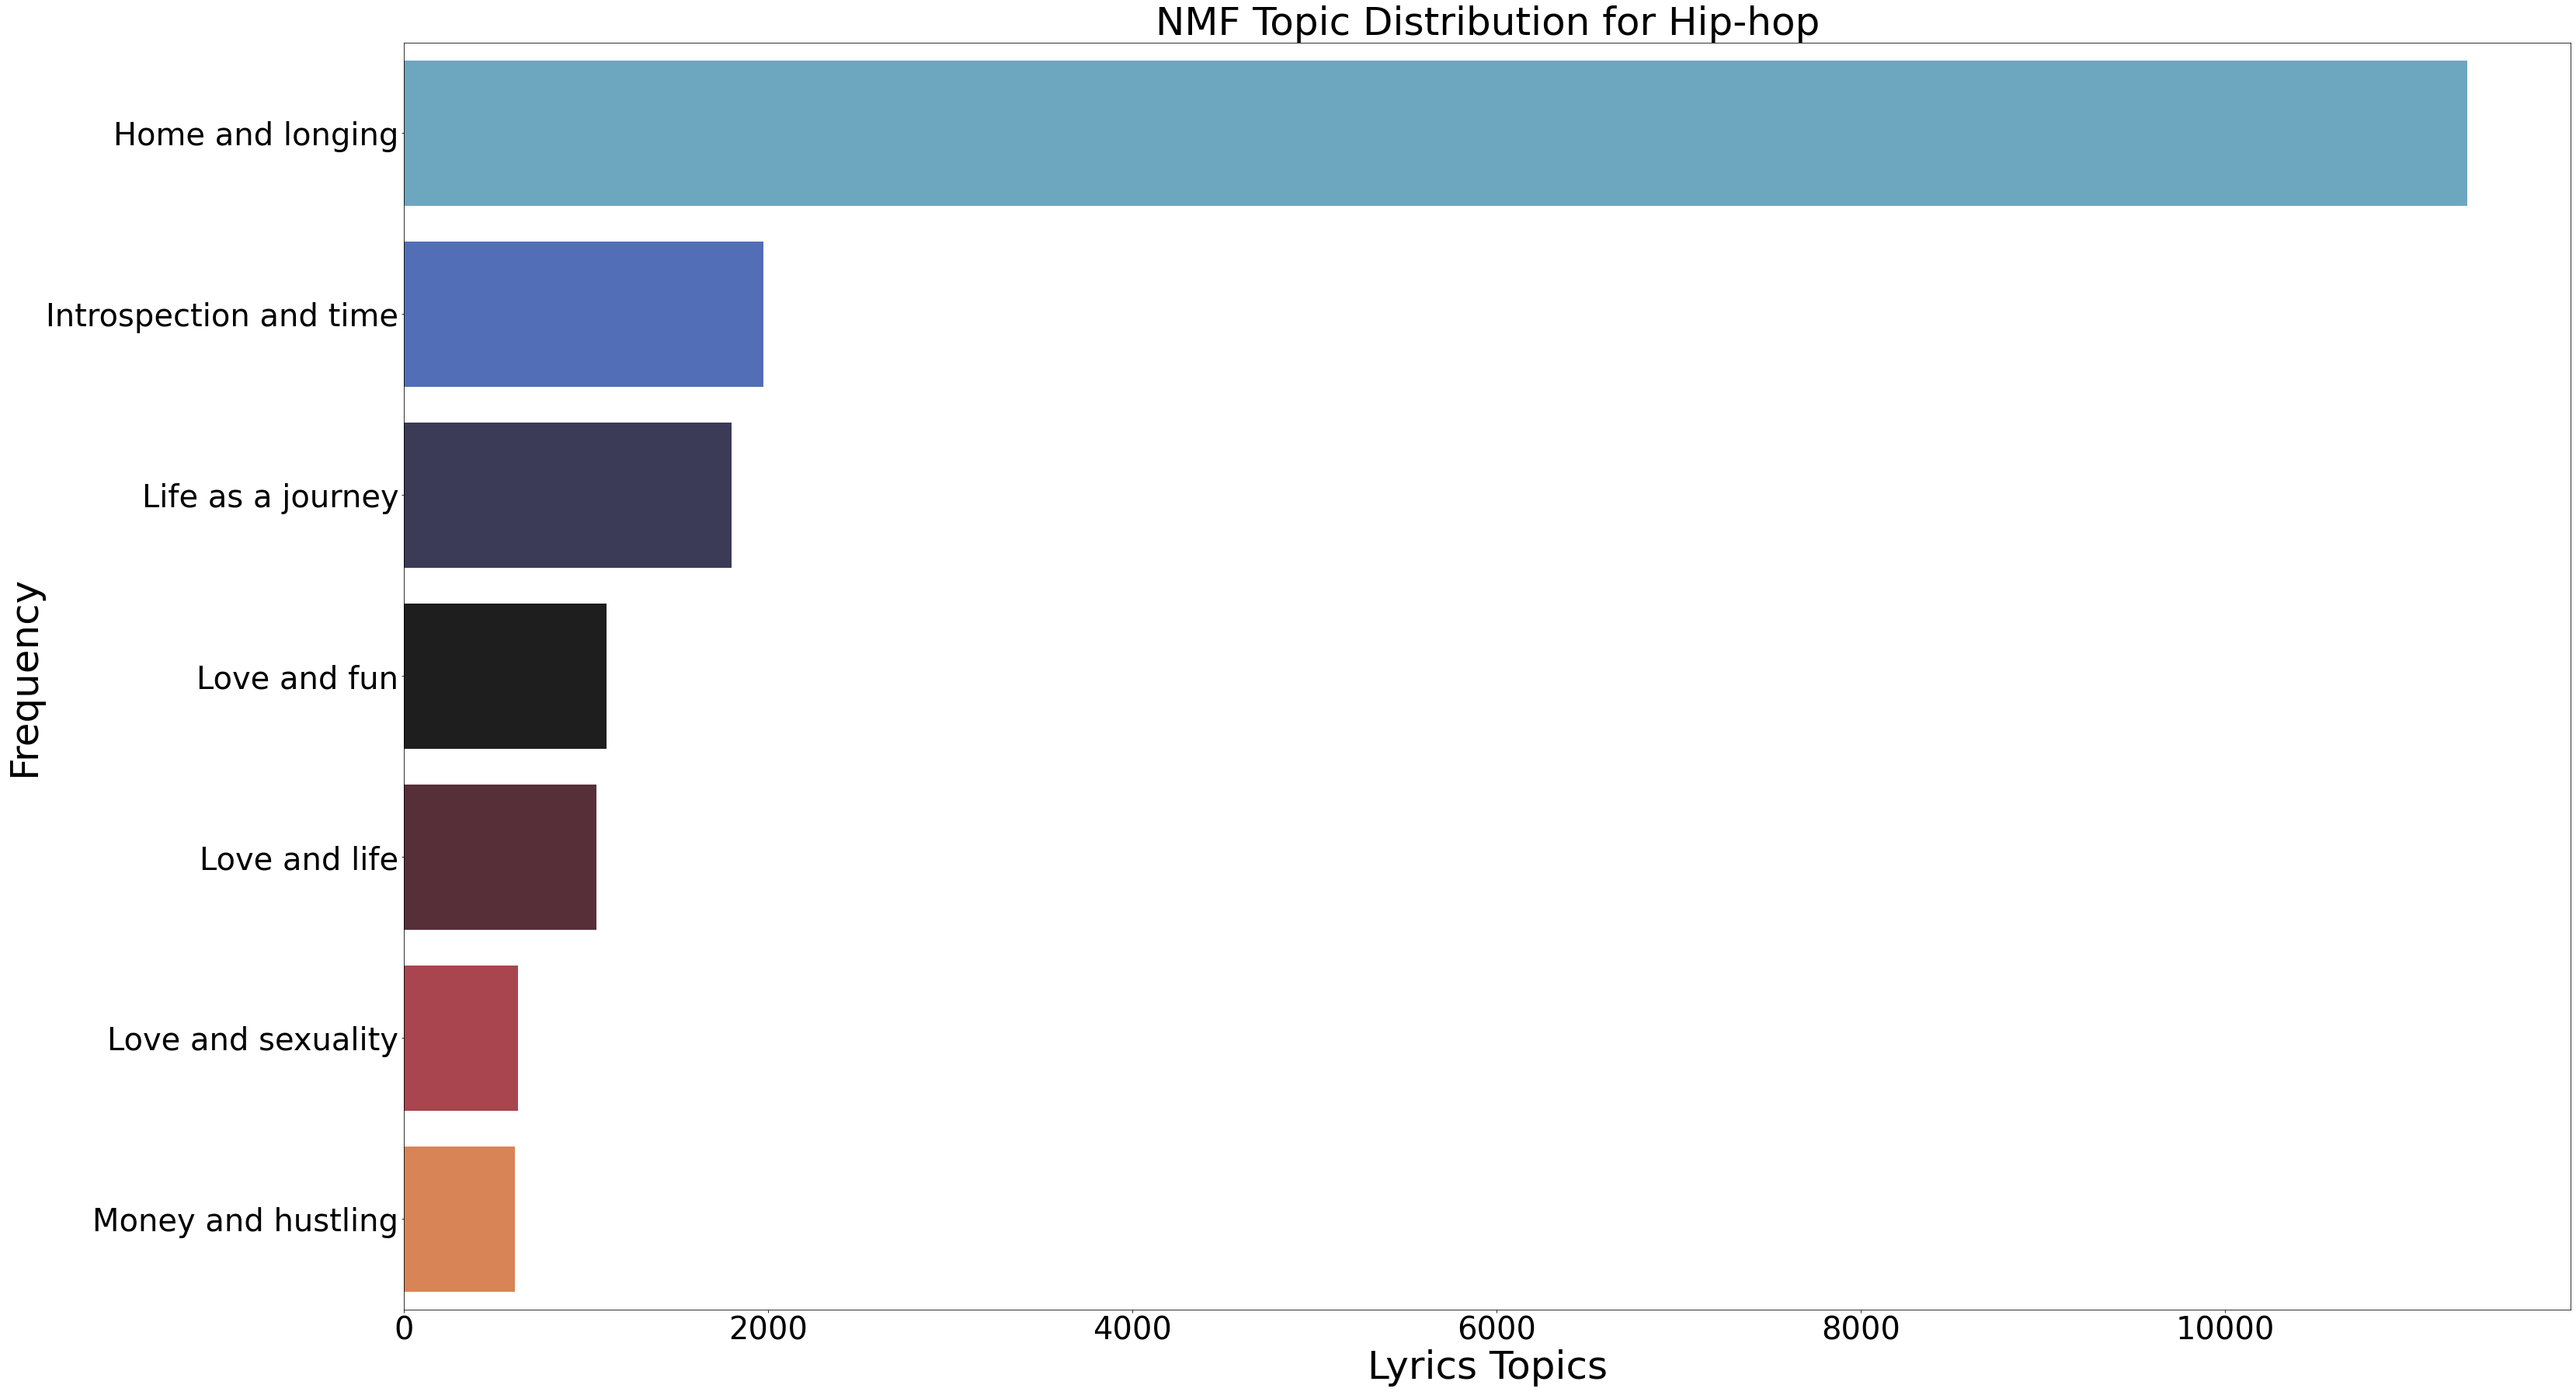

In [147]:
display_genre_topics('Hip-hop')

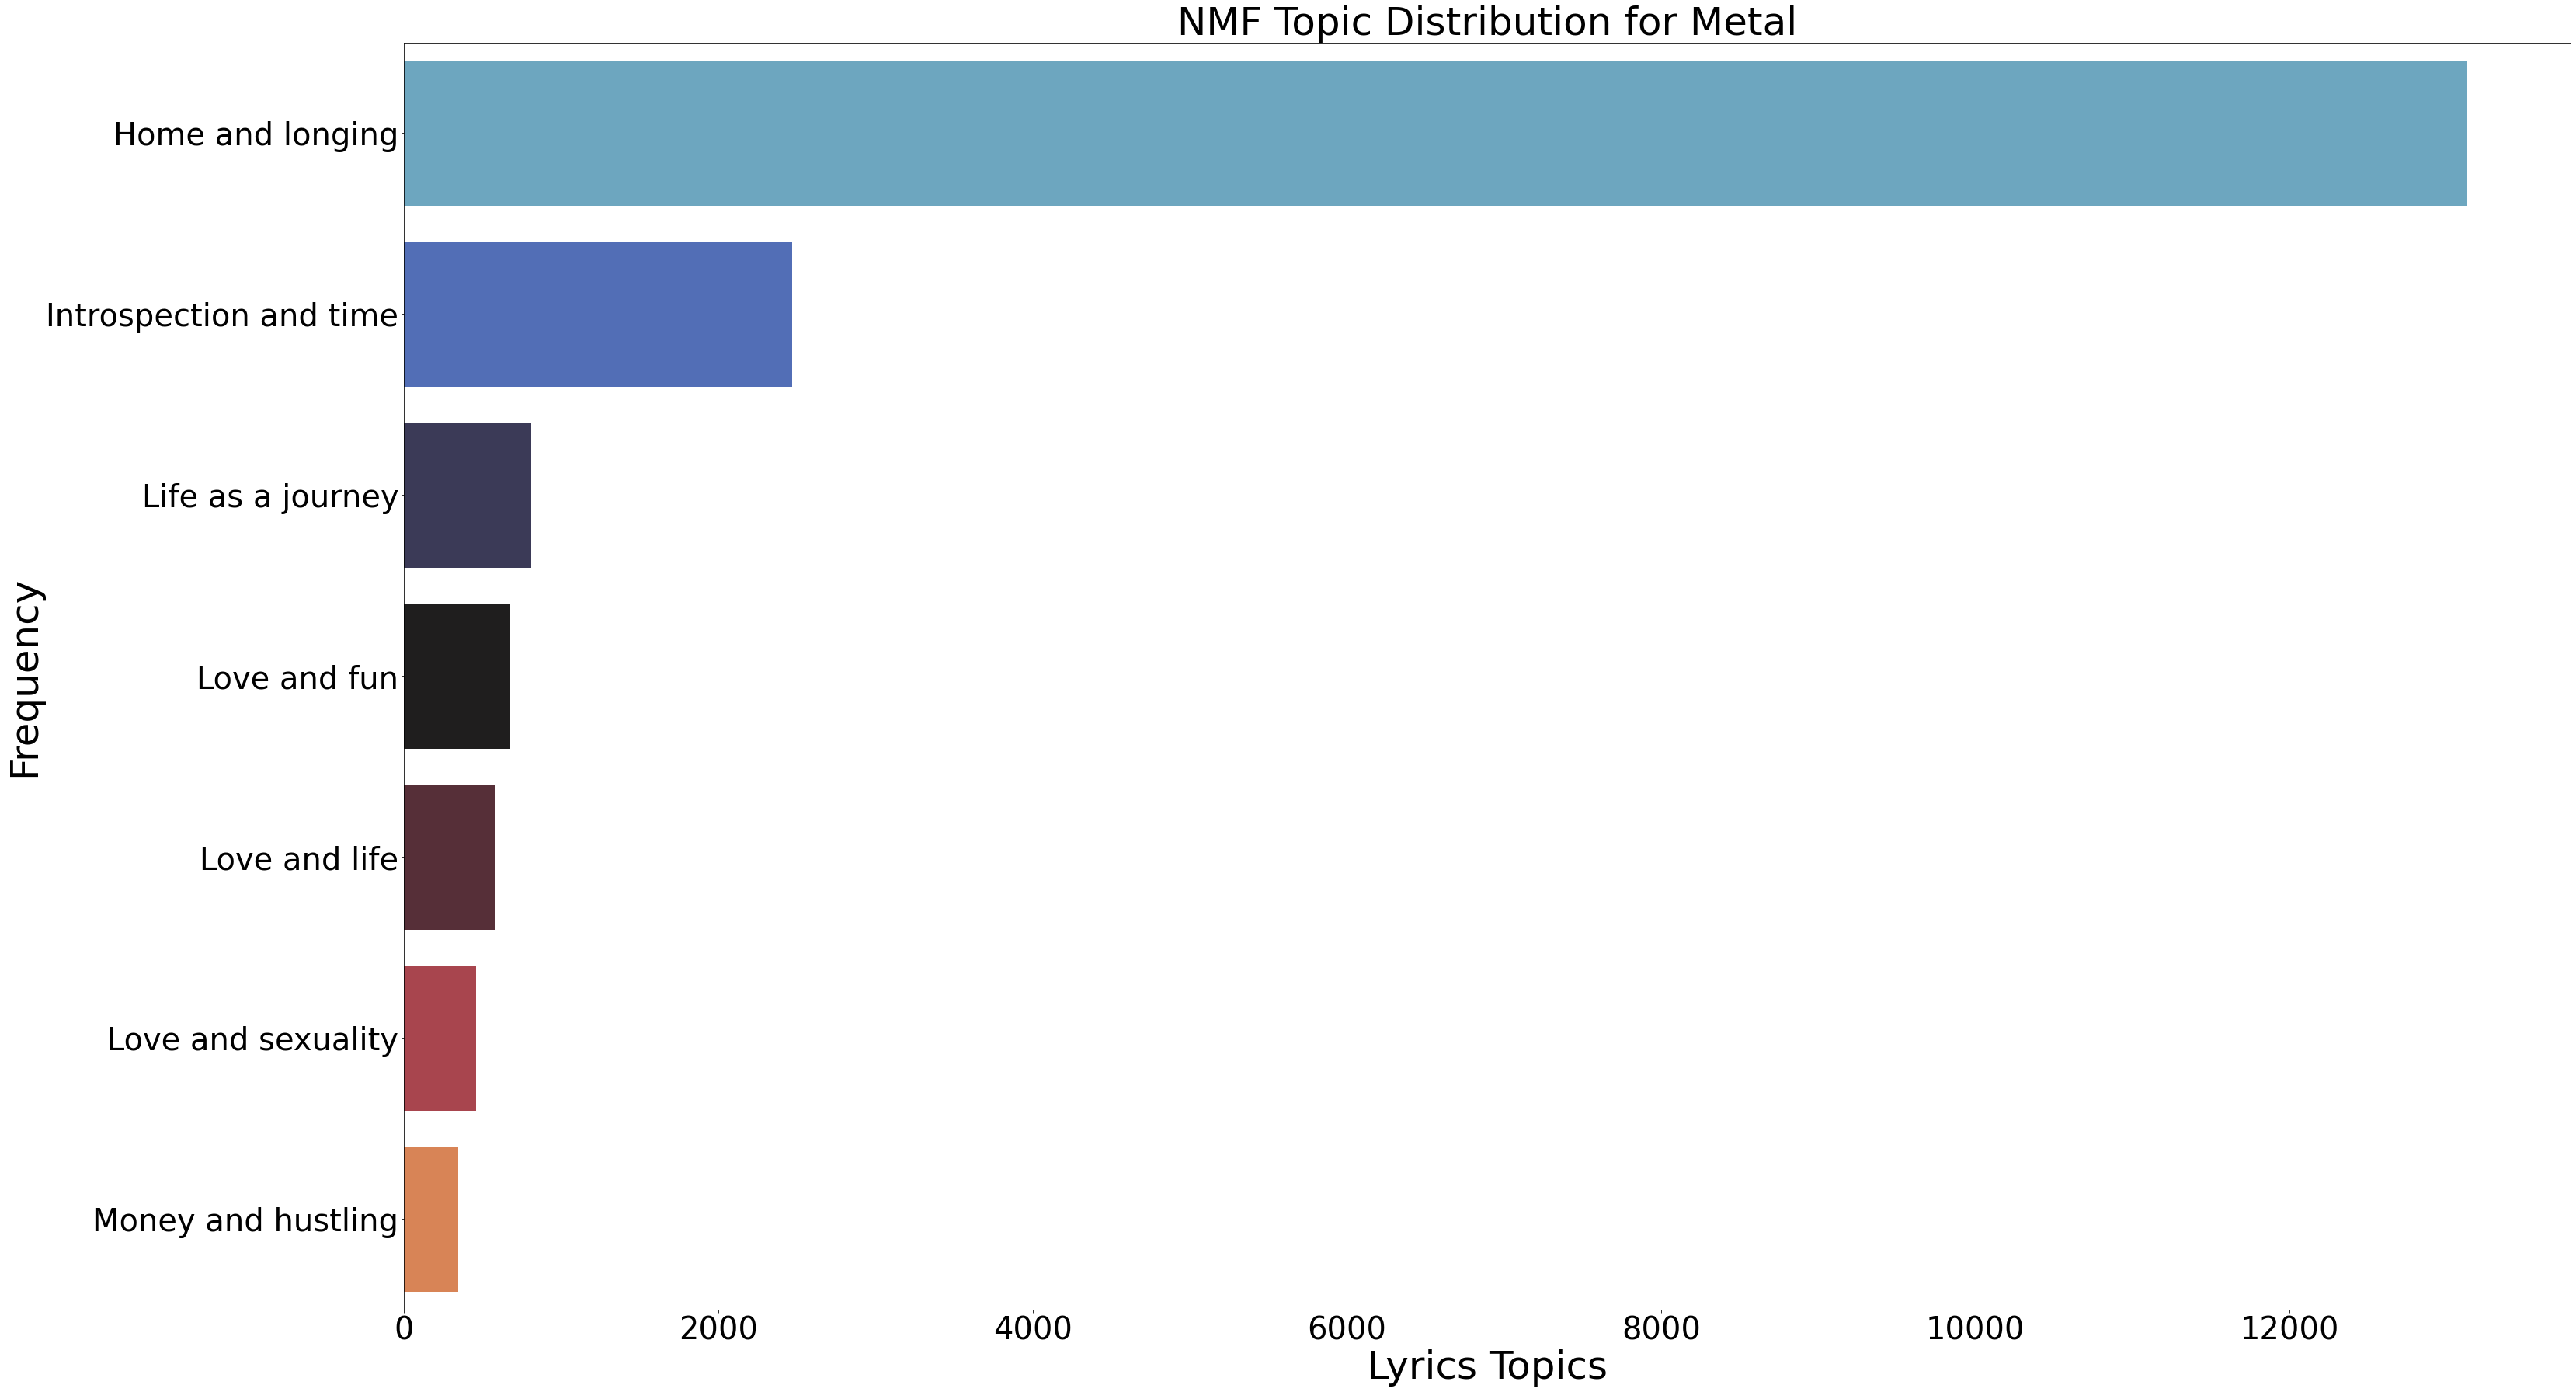

In [148]:
display_genre_topics('Metal')

The results above show that topics related to life, death, faith, time, and love recurr across genres, with each genre showing its own particularities in distribution.

In [150]:
#We save the original dataframe, as well as the document term matrix and the TF-IDF matrix.
songs.to_csv('data/lemmatized_lyrics.csv', index=False)
doc_term_matrix.to_csv('data/doc_term_matrix.csv', index=False)
doc_term_matrix_tfidf.to_csv('data/doc_term_matrix_tfidf.csv', index=False)